# Derivatives, Numerical Optimization, and Machine Learning

## Why we are looking into this

 * ML "Model training" generally is a form of numerical optimization -
   "minimizing the risk of a seriously off answer".
 * Common ML situation: "very many" optimization parameters (ballpark ~$10^4$ to $10^9$).
 * Being able to do numerical optimization with >10 parameters is very useful in itself.
 * Many approaches to numerical optimization of nonlinear functions use gradients.
 * So, we want to retrace/understand the steps that led to insights on how to efficiently compute gradients even for ${\mathbb R}^{1\,000\,000}\to{\mathbb R}$ objective functions.

But let us start simple with something we know - also to get some Python practice: Derivatives.


In [ ]:
# Importing the relevant Python libraries ("modules").
import math
import pprint
import time

import matplotlib
from matplotlib import pyplot
import numpy
import scipy.optimize
import tensorflow as tf

# Larger figures by default.
matplotlib.rcParams['figure.figsize'] = (16, 8)

First task: Given a simple function ("black box" - we can evaluate it at individual points, but not inspect its definition) "where all relevant scales (function value, gradient, curvature, etc.) are of magnitude 1", let us look into numerically computing the derivative at a given point.

In [ ]:
def derivative_v0(f, x0, eps=1e-6):
  """Estimates f'(x0) via finite differences.

  Args:
    f: Callable, the R->R function we want to compute the derivative of.
    x0: The position where to compute the derivative.
    eps: Step size.

  Returns:
    `(f(x0+eps) - f(x0)) / eps`, as a numerical approximation
    to the derivative.
  """
  return (f(x0 + eps) - f(x0)) / eps


def derivative_v1(f, x0, eps=1e-6):
  """Estimates f'(x0) via finite differences (symmetric difference).

  Args:
    f: Callable, the R->R function we want to compute the derivative of.
    x0: The position where to compute the derivative:
    eps: Step size.

  Returns:
    `(f(x0+eps) - f(x0-eps)) / (2*eps)`, as a numerical approximation
    to the derivative.
  """
  return (f(x0 + eps) - f(x0 - eps)) / (2 * eps)


def demo1(position=2.0, derivative=derivative_v0):
  f = lambda x: x**3
  for epsilon in (0.01, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10):
    df_dx = derivative(f, position, eps=epsilon)
    print(f"eps={str(epsilon):6s}: f'({position}) = approx. {df_dx}")



# Exploring Derivatives

In [ ]:
demo1()

eps=0.01  : f'(2.0) = approx. 12.060099999999707
eps=0.001 : f'(2.0) = approx. 12.006000999997823
eps=0.0001: f'(2.0) = approx. 12.000600010022566
eps=1e-05 : f'(2.0) = approx. 12.000060000261213
eps=1e-06 : f'(2.0) = approx. 12.000006002210739
eps=1e-07 : f'(2.0) = approx. 12.000000584322379
eps=1e-08 : f'(2.0) = approx. 11.999999927070348
eps=1e-09 : f'(2.0) = approx. 12.000000992884452
eps=1e-10 : f'(2.0) = approx. 12.000000992884452


In [ ]:
demo1(derivative=derivative_v1)

eps=0.01  : f'(2.0) = approx. 12.000099999999847
eps=0.001 : f'(2.0) = approx. 12.000000999998317
eps=0.0001: f'(2.0) = approx. 12.00000001000845
eps=1e-05 : f'(2.0) = approx. 12.00000000021184
eps=1e-06 : f'(2.0) = approx. 12.000000000789157
eps=1e-07 : f'(2.0) = approx. 11.99999999368373
eps=1e-08 : f'(2.0) = approx. 11.999999882661427
eps=1e-09 : f'(2.0) = approx. 12.000000992884452
eps=1e-10 : f'(2.0) = approx. 12.000000992884452


For normal-differencing, "if function-values and derivatives
are roughly on the scale of 1", we get 'best approximation'
for eps ~ 1e-8, which corresponds to about half the available
15-digit accuracy.

With smaller step sizes, we get more valid digits for the change-in-value, but representing the step-size itself numerically vs. the change-in-value becomes more inaccurate, and the best trade-off is "if step size splits the available accuracy in the middle".

---

For symmetric-differencing, this is a bit trickier to analyze, but as
we would expect, "larger step size gives us still good values for
higher order approximations."

The way to reason this out is as
follows: symmetric-differencing actually corresponds to how we would
obtain the linear term when fitting a Taylor polynomial to 2nd order,
evaluating the function at: (-eps, 0, +eps). For the linear term,
the weight of f(x0) just happens to be zero. If values are
"on the scale of 1", then a 3rd-order output-noise of 1e-15 is
created by an input-noise of ~1e-5.


## Question (Trick question?): What is the best step size for `derivative_v0`?

In [ ]:
# Explore yourself!
my_function = lambda x: x**3  # Or feel free to define any other function you like.
derivative_v0(my_function, 1.0, eps=0.01)

3.0301000000000133

### Answer (...which will lead us to FM-AD and RM-AD.)


In [ ]:
f = lambda x: x**3
print(derivative_v1(f, 1.0, eps=1e-15j))
# Also:
print(derivative_v1(f, 1.0, eps=1e-100j))

(3+0j)
(3+0j)


This may "look like cheating". What is going on here?

 * Quite a few Python functions are happy to take complex arguments.

 * (Python syntax for complex numbers: `{float_literal}[+-]{float_literal}j`.

    Also: `complex(2, 3) => 2+3j`; `j` as in electrical engineering,
    where `i` generally is current-density.)

 * Both for real and imaginary part, we have 64-bit floating point accuracy.

 * We are basically doing the computation for `x0+{fuzz}`.

 * Making the "fuzz" imaginary, the imaginary part of the quantities we
   compute tells us by how much the function's value changes as multiples
   of the imaginary fuzz, if we fuzz the input like this.
 * Note that `(k * 1e-15j)**2 = -(k**2) * 1e-30`.

   So if {function value} "is on the scale of 1", and we can represent
   numbers "to 15 digits behind the point (relative to that scale)",
   as long as this derivative k will be smaller in magnitude than 1e15,
   we get a "numerically accurate" result (= the derivative is as good
   as it gets with numerics, there are no higher order distortions).

 * (Feel free to try this out with a function with larger derivative, such as
    `(1 + 100*x)**4` at `x=1`.)

 * We sort-of abused complex numbers (and holomorphicity) here.
   But suppose we had a data type `complex0` that differed from the
   complex numbers by obeying $I^2=0$ rather than $i^2=-1$.
   These are the called "dual numbers". With those, we could just evaluate
   `f(x0+I)` and pick out the "imaginary part" to get the derivative.
   No need for this "1e-15" scaling.

 * Suppose now we had some ${\mathbb R}\to {\mathbb R^{1000}}$ function $f$.
   Using "dual numbers", we can easily compute $f'(x_0)$ alongside
   the computation of $f(x_0)$ "with little extra effort". ("little" ==
   "bounded by a small constant effort factor vs. original computation".)
   Doing this with a complex-numbers-like numeric data type is called
   "forward mode automatic differentiation (FMAD)".

 * We of course also could do this "Forward Mode AD" for 2, 3,
   etc. parameters, using an algebra of numbers `a+bI+cJ+dK+eL`
   where we have $I^2=IJ=IK=\ldots=K^2=KL=\ldots=L^2=0$
   ("all 2nd order quantities can be dropped").
   
   Having $n$ such "infinitesimals" basically multiplies the effort by $n$.

 * (In undergraduate physics, we typically encounter this idea in the form
   of "Gaussian error propagation".)

 * For *numerical optimization*, we have the opposite situation:
   *one* objective, but "thousands of parameters":
   ${\mathbb R}^{1000}\to{\mathbb R}$, not ${\mathbb R}\to{\mathbb R}^{1000}$.

 * There is a "dual trick" that makes this other case fast.
   This is known as "reverse mode automatic differentiation"
   ("RMAD", or just "AD"), or also "sensitivity backpropagation".

 * RMAD was first fully formalized as "this is an algorithm that transforms
   an algorithm computing $f$ into an efficient algorithm computing $f'$"
   in [Bert Speelpenning's 1980 PhD thesis](https://www.osti.gov/servlets/purl/5254402). Unaware of progress in numerical
   optimization / engineering, it was rediscovered in the much narrower
   context of neural networks (so, not as a generic algorithm-transformation)
   in 1985, [in a paper by Rummelhart, Hinton, and Williams](https://www.nature.com/articles/323533a0).
   Given that this was rediscovered many times in different contexts,
   it is hard to name an inventor. Seppo Linnainmaa might have been the
   first to put this onto computers in the 1970s, but one can demonstrate
   that the idea is very closely related to insights that go back to
   Lev Pontryagin, and even William Rowan Hamilton.

# Before we move on... a Python interlude.

Here is a function that maps some ${\mathbb R}\mapsto{\mathbb R}$
function `f` to a function numerically computing `f'` by finite-differencing:

In [ ]:
def numerical_derivative(f, default_eps=1e-7):
  """Maps a R->R function to its finite-differencing derivative-function."""
  def fprime(x0, eps=None):
    """Numerically computes the derivative."""
    # If the optional parameter 'eps' was provided, we use that as step size,
    # otherwise we use the value of `default_eps` from the (lexically) outer
    # function as it was at the point when code flow encountered the definition
    # of this inner function.
    epsilon = default_eps if eps is None else eps
    return (f(x0 + epsilon) - f(x0 - epsilon)) / (2 * epsilon)
  return fprime  # We return the derivative-function as a value!

Examples below. (Feel free to try out your own!)

In [ ]:
f1 = lambda x: math.sin(x)
f2 = lambda x: (1-x*x)**.5

f1prime = numerical_derivative(f1)
f2prime = numerical_derivative(f2, default_eps=1e-4)

print(f1prime(math.pi/4))
print(f1prime(math.pi/4, eps=1e-7))

print(f2prime(0.5))  # Uses the default eps-value 1e-4.
print(f2prime(0.5, eps=1e-7))

0.7071067803510189
0.7071067803510189
-0.5773502743211534
-0.5773502692596466


This is a beefed-up variant that uses some Python tricks we have not discussed yet, but is practically useful for symmetric-differencing a $K^{n_1\times n_2\times\ldots}\to K^{m_1\times m_2\times\ldots}$ tensor-valued function - for $K={\mathbb R}$ or $K={\mathbb C}$ - of coordinates that in themselves may be tensor-valued:

In [ ]:
def n_grad(f, eps=1e-8):
  """Maps a tensor-valued function of tensor-coordinates to a gradient-function."""
  def grad_f(xs):
    xs = numpy.asarray(xs)
    xs0 = xs.ravel()
    dim = xs.size
    xs1 = xs0.copy()
    f0 = numpy.asarray(f(xs0.reshape(xs.shape)))
    result = numpy.zeros(f0.shape + (dim,))
    for n in range(dim):
      xs1[n] = xs0[n] + eps
      fplus = numpy.asarray(f(xs1.reshape(xs.shape)))
      xs1[n] = xs0[n] - eps
      fminus = numpy.asarray(f(xs1.reshape(xs.shape)))
      xs1[n] = xs0[n]
      result[..., n] = (fplus - fminus) / (2 * eps)
    return result.reshape(f0.shape + xs.shape)
  return grad_f

# Example: the gradient of matrix-squaring evaluated at the 2x2-identity -
# which is a [2,2,2,2]-tensor.
grad_matrix_squaring = n_grad(lambda m: m @ m)
print(grad_matrix_squaring(numpy.eye(2)).round(3))


[[[[2. 0.]
   [0. 0.]]

  [[0. 2.]
   [0. 0.]]]


 [[[0. 0.]
   [2. 0.]]

  [[0. 0.]
   [0. 2.]]]]


# Reverse Mode AD, Step-by-Step


We need a simple-but-not-too-simple toy function to discuss the idea behind Reverse-mode AD.

Suppose you have a 4d box (3d would lead to "too simple" an example) with edge lengths $a, b, c, d$. The hypersurface of this box is given by the following function.

(Note that putting an $\epsilon$-thickness layer of paint onto a 4d such box would require ${\rm Vol}(a+\epsilon,b+\epsilon,c+\epsilon,d+\epsilon)-{\rm Vol}(a,b,c,d)+{\mathcal O}(\epsilon^2)$ much paint, and dividing by $\epsilon$ gives us the surface area, just as "summing the surface 3d-boxes" does.)

In [ ]:
def box4d_hypersurface(a, b, c, d):
  """Hypersurface of a 4d box with edge lengths a, b, c, d."""
  # We try to maximize sharing of computations, so rather than computing
  # a * b * c + a * b * d, etc., we remember intermediate products.
  ab = a * b
  cd = c * d
  abc = ab * c
  abd = ab * d
  acd = a * cd
  bcd = b * cd
  half_hypersurface = abc + abd + acd + bcd
  hypersurface = 2 * half_hypersurface
  # Normally, we would instead just do:
  #   return 2 * (abc + abd + acd + bcd)
  # ...but doing smaller steps will be useful for the subsequent discussion.
  return hypersurface

In [ ]:
# Merely ensuring that this computes a plausible value at all for some simple case.
print(box4d_hypersurface(10, 10, 10, 10))

8000


Starting from the function definition above, let us manually implement a function that "computes the gradient at a given point".

For some given point `(a, b, c, d)`, we want to know
`grad(box4d_hypersurface)(a, b, c, d)`, i.e. "by how much does the hypersurface change if we tweak `a` by $\epsilon$ (relative to $\epsilon$), and likewise for `b`, `c`, `d`.

People did this sort of thing (manually implementing gradients) for quite a while, and gradually realized a few tricks that condensed into this generally-applicable recipe. Here: for "straight" functions without loops (as this all was understood around 1976 already) - and subsequently, for code with branches and loops and other control structure.

**The Recipe**

 1. Copy the code that computes the function.
    Efficiently computing the gradient will start with computing
    the forward-function.
    
    Do make sure the function is written
    in such a way that intermediate results never are overwritten.

    (This already holds for our example.)

 1. Comment out the final 'return ...' statement.

    Rather than returning that value, we will have to do more work afterwards.

 1. There will (in general) be quite a few intermediate quantities
    for this calculation. For the $k$-th such intermediate quantity - $q_k$,
    we introduce a "sensitivity accumulator" $S_{q_k}$,
    which initially is initialized to zero right at the point where $q_k$
    is introduced.

 1. We also treat the inputs and the output as "intermediate quantities".

 1. Right from the point where we could return the result, go through
    the calculation once again, but this time backwards, step-by-step,
    from each intermediate quantity back to earlier ones in terms of
    which it is defined. While doing so, maintain this invariant:

    Each such "sensitivity accumulator" $S_{q_k}$ keeps track of
    "by how much would the final result of this function change,
    relative to $\epsilon$, if I intercepted code flow right after
    this line in the calculation that uses the quantity $q_k$,
    and made an ad-hoc change to $q_k$, incrementing it by $\epsilon$?

Once we know the sensitivities of the final result on the input parameters, we have our gradient.

Let us apply this recipe step-by-step.

In [ ]:
# Step 1: Copying the code.

def box4d_hypersurface_step1(a, b, c, d):
  """Hypersurface of a 4d box with edge lengths a, b, c, d."""
  # We try to maximize sharing of computations, so rather than computing
  # a * b * c + a * b * d, etc., we remember intermediate products.
  ab = a * b
  cd = c * d
  abc = ab * c
  abd = ab * d
  acd = a * cd
  bcd = b * cd
  half_hypersurface = abc + abd + acd + bcd
  hypersurface = 2 * half_hypersurface
  # Normally, we would instead just do:
  #   return 2 * (abc + abd + acd + bcd)
  # ...but doing smaller steps will be useful for the subsequent discussion.
  return hypersurface


# Step 2: Removing the `return ...`

def box4d_hypersurface_step2(a, b, c, d):
  """Hypersurface of a 4d box with edge lengths a, b, c, d."""
  # We try to maximize sharing of computations, so rather than computing
  # a * b * c + a * b * d, etc., we remember intermediate products.
  ab = a * b
  cd = c * d
  abc = ab * c
  abd = ab * d
  acd = a * cd
  bcd = b * cd
  half_hypersurface = abc + abd + acd + bcd
  hypersurface = 2 * half_hypersurface
  # Normally, we would instead just do:
  #   return 2 * (abc + abd + acd + bcd)
  # ...but doing smaller steps will be useful for the subsequent discussion.
  ### Rather than returning the value, proceed to compute the gradient.
  ### return hypersurface


# Step 3: Introduce sensitivity accumulators.
#
# Note: Using Semicolons is generally frowned-upon-style in Python,
# but here it comes handy for didactic purposes.
# Still: avoid this "in real code".

def box4d_hypersurface_step3(a, b, c, d):
  """Hypersurface of a 4d box with edge lengths a, b, c, d."""
  # We try to maximize sharing of computations, so rather than computing
  # a * b * c + a * b * d, etc., we remember intermediate products.
  ab = a * b; s_ab = 0
  cd = c * d; s_cd = 0
  abc = ab * c; s_abc = 0
  abd = ab * d; s_abd = 0
  acd = a * cd; s_acd = 0
  bcd = b * cd; s_bcd = 0
  half_hypersurface = abc + abd + acd + bcd; s_half_hypersurface = 0
  hypersurface = 2 * half_hypersurface
  # Normally, we would instead just do:
  #   return 2 * (abc + abd + acd + bcd)
  # ...but doing smaller steps will be useful for the subsequent discussion.
  ### Rather than returning the value, proceed to compute the gradient.
  ### return hypersurface

# Step 4: Also do this for the inputs and for the result value.

def box4d_hypersurface_step4(a, b, c, d):
  """Hypersurface of a 4d box with edge lengths a, b, c, d."""
  # We try to maximize sharing of computations, so rather than computing
  # a * b * c + a * b * d, etc., we remember intermediate products.
  s_a = 0; s_b = 0; s_c = 0; s_d = 0   # <== !!!
  ab = a * b; s_ab = 0
  cd = c * d; s_cd = 0
  abc = ab * c; s_abc = 0
  abd = ab * d; s_abd = 0
  acd = a * cd; s_acd = 0
  bcd = b * cd; s_bcd = 0
  half_hypersurface = abc + abd + acd + bcd; s_half_hypersurface = 0
  ### Rather than returning the value, proceed to compute the gradient.
  ### return hypersurface
  # !!! `hypersurface` is our result value. We already know the final
  # !!!  value of `s_hypersurface`: If we intercepted the calculation after
  # !!! `hypersurface = 2 * ...`, and added a change-forcing line...:
  # !!!    hypersurface = hypersurface + epsilon
  # !!!  this would (trivially) change the function's result by epsilon.
  # !!!  So, s_hypersurface = 1.
  hypersurface = 2 * half_hypersurface; s_hypersurface = 1
  # Normally, we would instead just do:
  #   return 2 * (abc + abd + acd + bcd)
  # ...but doing smaller steps will be useful for the subsequent discussion.

# Step 5 ("backpropagation") - we do this one-by-one.

def box4d_hypersurface_step5a(a, b, c, d):
  """Hypersurface of a 4d box with edge lengths a, b, c, d."""
  # We try to maximize sharing of computations, so rather than computing
  # a * b * c + a * b * d, etc., we remember intermediate products.
  s_a = 0; s_b = 0; s_c = 0; s_d = 0   # <== !!!
  ab = a * b; s_ab = 0
  cd = c * d; s_cd = 0
  abc = ab * c; s_abc = 0
  abd = ab * d; s_abd = 0
  acd = a * cd; s_acd = 0
  bcd = b * cd; s_bcd = 0
  half_hypersurface = abc + abd + acd + bcd; s_half_hypersurface = 0
  hypersurface = 2 * half_hypersurface; s_hypersurface = 1
  ### Rather than returning the value, proceed to compute the gradient.
  ### return hypersurface
  # Forward-computation:
  #    hypersurface = 2 * half_hypersurface
  # If we had added a line right before this that reads:
  #    half_hypersurface = half_hypersurface + eps
  # ...this would change `hypersurface` by 2 * eps, and the end result by
  # 2 * eps * {sensitivity of the end result on `hypersurface`}
  # (this is the chain rule). So, `s_half_hypersurface` receives a contribution:
  s_half_hypersurface = s_half_hypersurface + 2 * s_hypersurface
  # (From now on, we will just write this:
  #    s_half_hypersurface += 2 * s_hypersurface
  #  ...even though one should in general stay away from the += operator
  #  in Python, at least while learning the language.)

# Then...

def box4d_hypersurface_step5b(a, b, c, d):
  """Hypersurface of a 4d box with edge lengths a, b, c, d."""
  # We try to maximize sharing of computations, so rather than computing
  # a * b * c + a * b * d, etc., we remember intermediate products.
  s_a = 0; s_b = 0; s_c = 0; s_d = 0   # <== !!!
  ab = a * b; s_ab = 0
  cd = c * d; s_cd = 0
  abc = ab * c; s_abc = 0
  abd = ab * d; s_abd = 0
  acd = a * cd; s_acd = 0
  bcd = b * cd; s_bcd = 0
  half_hypersurface = abc + abd + acd + bcd; s_half_hypersurface = 0
  hypersurface = 2 * half_hypersurface; s_hypersurface = 1
  ### Rather than returning the value, proceed to compute the gradient.
  ### return hypersurface
  # Forward-computation:
  #    hypersurface = 2 * half_hypersurface
  s_half_hypersurface += 2 * s_hypersurface
  # Forward-computation:
  #    half_hypersurface = abc + abd + acd + bcd
  s_abc += s_half_hypersurface
  s_abd += s_half_hypersurface
  s_acd += s_half_hypersurface
  s_bcd += s_half_hypersurface

# Then:

def box4d_hypersurface_step5c(a, b, c, d):
  """Hypersurface of a 4d box with edge lengths a, b, c, d."""
  # We try to maximize sharing of computations, so rather than computing
  # a * b * c + a * b * d, etc., we remember intermediate products.
  s_a = 0; s_b = 0; s_c = 0; s_d = 0   # <== !!!
  ab = a * b; s_ab = 0
  cd = c * d; s_cd = 0
  abc = ab * c; s_abc = 0
  abd = ab * d; s_abd = 0
  acd = a * cd; s_acd = 0
  bcd = b * cd; s_bcd = 0
  half_hypersurface = abc + abd + acd + bcd; s_half_hypersurface = 0
  hypersurface = 2 * half_hypersurface; s_hypersurface = 1
  ### Rather than returning the value, proceed to compute the gradient.
  ### return hypersurface
  # Forward-computation:
  #    hypersurface = 2 * half_hypersurface
  s_half_hypersurface += 2 * s_hypersurface
  # Forward-computation:
  #    half_hypersurface = abc + abd + acd + bcd
  s_abc += s_half_hypersurface
  s_abd += s_half_hypersurface
  s_acd += s_half_hypersurface
  s_bcd += s_half_hypersurface
  # Forward-computation:
  #     bcd = b * cd
  # For each of the factors, sensitivity = {sensitivity of the
  # end result on the left hand side intermediate quantity, which we at
  # this point fully know, since we reached the definition of this quantity,
  # and all its uses come after the definition} * {other-factor, which scales it}.
  # (This is just the product rule in action).
  s_b += s_bcd * cd
  s_cd += b * s_bcd

# Proceeding further like this, now doing larger steps -
# and completing the work.

def box4d_hypersurface_and_gradient(a, b, c, d):
  """Hypersurface of a 4d box with edge lengths a, b, c, d."""
  # We try to maximize sharing of computations, so rather than computing
  # a * b * c + a * b * d, etc., we remember intermediate products.
  s_a = 0; s_b = 0; s_c = 0; s_d = 0   # <== !!!
  ab = a * b; s_ab = 0
  cd = c * d; s_cd = 0
  abc = ab * c; s_abc = 0
  abd = ab * d; s_abd = 0
  acd = a * cd; s_acd = 0
  bcd = b * cd; s_bcd = 0
  half_hypersurface = abc + abd + acd + bcd; s_half_hypersurface = 0
  hypersurface = 2 * half_hypersurface; s_hypersurface = 1
  ### Rather than returning the value, proceed to compute the gradient.
  ### return hypersurface
  # Forward-computation:
  #    hypersurface = 2 * half_hypersurface
  s_half_hypersurface += 2 * s_hypersurface
  # Forward-computation:
  #    half_hypersurface = abc + abd + acd + bcd
  s_abc += s_half_hypersurface
  s_abd += s_half_hypersurface
  s_acd += s_half_hypersurface
  s_bcd += s_half_hypersurface
  # Forward-computation:
  #     bcd = b * cd
  s_b += s_bcd * cd
  s_cd += b * s_bcd
  # Forward-computation:
  #     acd = a * cd
  s_a += s_acd * cd
  s_cd += a * s_acd  # Note that this 2nd(-in-reverse-order) use of `cd`
                     # introduces a 2nd contribution to `s_cd`!
  # Forward-Computation:
  #     abd = ab * d
  s_ab += s_abd * d
  s_d += ab * s_abd
  # Forward-computation:
  #     abc = ab * c
  s_ab += s_abc * c
  s_c += ab * s_abc
  # Forward-computation:
  #     cd = c * d
  s_c += s_cd * d
  s_d += c * s_cd
  # Forward-computation:
  #    ab = a * b
  s_a += s_ab * b
  s_b += a * s_ab
  ### At this point, we know the sensitivities of the result on the vector of
  ### input-coordinates. That is just the gradient.
  ### "Since we can", we also return the function's value (as it may be useful):
  return (hypersurface, (s_a, s_b, s_c, s_d))


In [ ]:
# Let's try it out...:

print(box4d_hypersurface_and_gradient(2, 5, 7, 11))
print(derivative_v1((lambda x: box4d_hypersurface(2, x, 7, 11)), 5, eps=1e-15j))



(1438, (334, 226, 174, 118))
(225.99999999999997+0j)


## Computational Complexity

When reasoning about the effort needed to obtain a good gradient, a key observation is that "per use of an intermediate quantity", the effort is a fixed multiple of the corresponding effort done on the forward-calculation.

"The most painful thing that can happen" is back-propagating through a product. We need to zero-initialize two sensitivity-accumulators (somewhere), and to what extent this can be amortized depends e.g. on the operating system and code structure. Then, we need to load these accumulators, add the increments, and store them again. Computing the increments requires a multiplication each. We can write down effort as a function of the relative cost of load/add/multiply/store operations, and then study the range of the {gradient effort} / {forward pass effort} function as a function of these costs. Speelpenning's thesis gives a bound of "at most 8x effort", but one can reason out "at most 6x", and in practice one often observes "factor 4-5, rarely around 6". However, on real computers, cache performance also is an issue here.

In [ ]:
# Hand-backpropagation can be a bit tedious, and one needs to be extremely
# careful to avoid typos, but the good news is: If something is off, we can
# always modify the forward-calculation "to allow injecting epsilon changes"
# and then compare "measured" and "computed" sensitivities, zeroing in
# on the location of the problem.
#
# This might roughly look as follows...:


def box4d_hypersurface_perturbed(a, b, c, d, eps_cd=0, eps_abc=0):
  """Hypersurface of a 4d box with edge lengths a, b, c, d."""
  # We try to maximize sharing of computations, so rather than computing
  # a * b * c + a * b * d, etc., we remember intermediate products.
  ab = a * b
  cd = c * d + eps_cd
  abc = ab * c + eps_abc
  abd = ab * d
  acd = a * cd
  bcd = b * cd
  half_hypersurface = abc + abd + acd + bcd
  hypersurface = 2 * half_hypersurface
  # Normally, we would instead just do:
  #   return 2 * (abc + abd + acd + bcd)
  # ...but doing smaller steps will be useful for the subsequent discussion.
  return hypersurface

print((box4d_hypersurface_perturbed(2, 5, 10, 20, eps_cd=1e-7) -
       box4d_hypersurface_perturbed(2, 5, 10, 20)) / 1e-7)
# ...which we then can compare against the finalized s_cd, respectively s_abc.

# We will see a more complicated semi-realistic worked out example below which
# still has some of its gradient debug code deliberately left in.

13.999997463542968


## More complicated code structure

Having seen the basic idea, it is natural to next discuss three generalizing aspects:

 1. "data-parallelism".
 1. Conditionals
 1. Loops

What we have seen so far looks at individual number-additions and multiplications.

However, the reasoning carries over straightaway to tensor arithmetics.

Let's look at an example for backpropagating through some matrix/tensor operation.

For pedagogical reasons (and also to practice using einsum()),
we will convert all (multi)linear operations to tensor contractions.

"Once we know how to backprop through einsum(), we understood how to do this for tensor arithmetics."



In [ ]:
# Backpropagating tensor operations.

G_NEWTON = 6.672e-11 # m^3 kg^(-1) s^(-2)

def gravitational_potential(m1, m2, pos1, pos2):
  v1 = numpy.asarray(pos1, dtype=numpy.float64)
  v2 = numpy.asarray(pos2, dtype=numpy.float64)
  v12 = v2 - v1
  dist_squared = numpy.einsum('i,i->', v12, v12)
  dist = dist_squared**.5
  m12 = m1 * m2
  Gm1m2 = G_NEWTON * m12
  energy = Gm1m2 / dist
  return -energy

# We backpropagate into every parameter here.
def gravitational_potential_and_grad(m1, m2, pos1, pos2):
  s_m1 = 0; s_m2 = 0
  v1 = numpy.asarray(pos1, dtype=numpy.float64) ; s_v1 = numpy.zeros_like(v1)
  v2 = numpy.asarray(pos2, dtype=numpy.float64) ; s_v2 = numpy.zeros_like(v2)
  v12 = v2 - v1; s_v12 = numpy.zeros_like(v12)
  dist_squared = numpy.einsum('i,i->', v12, v12); s_dist_squared = 0
  dist = dist_squared**.5; s_dist = 0
  m12 = m1 * m2 ; s_m12 = 0
  Gm1m2 = G_NEWTON * m12; s_Gm1m2 = 0
  energy = Gm1m2 / dist; s_energy = 0
  # return -energy
  s_energy += -1
  s_Gm1m2 += s_energy / dist
  # Here, we nomimally would have to use "inv_dist" as an intermediate quantity
  # and backprop through f(x)=1/x, but let's shorten this.
  s_dist += s_energy * Gm1m2 * (-1 / dist_squared)
  s_m12 = G_NEWTON * s_Gm1m2
  s_m1 += s_m12 * m2
  s_m2 += m1 * s_m12
  s_dist_squared += s_dist * 0.5 / dist
  # These two could of course be combined into a simple
  # s_v12 += 2 * s_dist_squared * v12
  s_v12 += numpy.einsum(',i->i', s_dist_squared, v12)
  s_v12 += numpy.einsum('i,->i', v12, s_dist_squared)
  s_v2 += s_v12
  s_v1 -= s_v12  # Note -= !
  return -energy, (s_m1, s_m2, s_v1, s_v2)



pprint.pprint(gravitational_potential_and_grad(2e7, 3e7, [5, 10, 15], [5, 20, 30]))
def debug_potential_1parameter(x):
  return gravitational_potential(2e7, 3e7, [5, 10, 15 + x], [5, 20, 30])
print('===')
pprint.pprint(derivative_v1(debug_potential_1parameter, 0.0, eps=1e-8))

(-2220.5758255288374,
 (-0.00011102879127644187,
  -7.401919418429458e-05,
  array([   0.        ,  -68.32541002, -102.48811502]),
  array([  0.        ,  68.32541002, 102.48811502])))
===
-102.48811577184824


So, not breaking up tensor arithmetics into individual additions
and multiplications and then doing backpropagation on this makes
less sense than keeping the tensor arithmetics intact.

Next, let us look into some nontrivial control structure. We will use Heron's method for root finding by iteratively averaging {candidate-root} and {square}/{candidate-root}.

In [ ]:
def heron_root(x, max_distance=1e-7):
  """Computes sqrt(x) by iterative averaging."""
  y = 1
  while True:
    x_div_y = x / y
    mid = 0.5 * (y + x_div_y)
    if abs(x_div_y - y) <= max_distance:
      return mid
    else:
      y = mid

print(heron_root(2))

1.414213562373095


Our first task is to convert this simple function to a form that "remembers all intermediate quantities, and never overwrites anything".

For the sake of clarity, this form deliberately ignores some optimization opportunities. Rather, we emphasize "understandability" here (and also get to see some useful new Python).

In [ ]:
import dataclasses

# Nominally, we are introducing a class here,
# but there is no actual state-management: The `HeronState`
# instance is effectively just a fancy tuple with named slots.
@dataclasses.dataclass(frozen=True)
class HeronState:
  y : float
  x_div_y : float
  mid : float
  delta : float

def heron_root_v1(x, max_distance=1e-7):
  """Computes sqrt(x) by iterative averaging."""
  states = []
  y = 1
  while True:
    x_div_y = x / y
    mid = 0.5 * (y + x_div_y)
    delta = x_div_y - y
    if abs(delta) <= max_distance:
      return mid
    else:
      y = mid


Next, we can think about backpropagating this.


In [ ]:
def heron_root_and_grad(x, max_distance=1e-7):
  """Computes sqrt(x) and by iterative averaging - plus its gradient."""
  states = []
  y = 1
  while True:
    x_div_y = x / y
    mid = 0.5 * (y + x_div_y)
    delta = x_div_y - y
    states.append(HeronState(y=y, x_div_y=x_div_y, mid=mid, delta=delta))
    if abs(delta) <= max_distance:
      # Rather than returning to the caller, we need to exit to after-the-loop.
      # return mid
      break
    else:
      y = mid
  # At this point,
  # - The result we would have returned is in `mid`.
  # - List entry `states[n]` contains intermediate quantites right at the end
  #   of iteration n, before we updated `y`.
  result = mid
  s_x = 0
  s_mid = 1
  for state in reversed(states):
    s_y = 0.5 * s_mid
    s_x_div_y = 0.5 * s_mid
    s_x += s_x_div_y / state.y
    s_y += s_x_div_y * x * (-1 / (state.y * state.y))
    # At the end of the previous loop, s_y was assigned from `mid`.
    s_mid = s_y
  # Here, it turns out that we actually would not have had to remember `delta`,
  # since this was not used as an intermediate quantity, but only to make
  # some continue-or-not decisions that became retraceable via the bookkeeping
  # we do with `states`.
  # Let us return some more detailed information.
  return dict(result=result,
              num_iterations=len(states),
              grad=s_x)


print(heron_root_and_grad(100.0))
print('###')
# Given that this method is reasonably efficient, we have to pick really large
# max_distance values to make it "use too few iterations".
# The question here is: Do these cases then produce good gradients?
print(heron_root_and_grad(100.0, max_distance=10))
print(derivative_v1(
    (lambda x: heron_root(x, max_distance=10)),
    100.0,
    eps=1e-7))
print('###')
print(heron_root_and_grad(100.0, max_distance=50))
print(derivative_v1(
    (lambda x: heron_root(x, max_distance=50)),
    100.0,
    eps=1e-7))

{'result': 10.0, 'num_iterations': 8, 'grad': 0.05}
###
{'result': 10.840434673026925, 'num_iterations': 4, 'grad': 0.06835572803193413}
0.06835572108343513
###
{'result': 26.24009900990099, 'num_iterations': 2, 'grad': 0.2500980296049407}
0.25009802229192246


So, backpropagating through loops is generally a bit more messy, but actually doable - even if the number of iterations is data-dependent.

The basic principle is: When computing the gradient, as we are retracing the computational steps, we make every computational flow decision (which branch to take, when to leave a loop) as on the forward computation.


# Actually doing optimization

Now that we have a way to efficiently get good gradients of even high-dimensional objective functions, let us actually explore what we can do with this. Numerical optimization obviously is an important topic in itself.

For the time being, let us focus on simple non-ML problems to practice gradient-based numerical optimization with `<=1000` parameters.

The short story here is: For nonlinear minimization, if the function can be approximated by some quadric near the minimum in some reasonable sense, and if it does not have too weird 'hole on the golf course' minima, the BFGS-family of algorithms (Broyden-Fletcher-Goldfarb-Shanno) generally are a very potent tool one should know about. The most general one that is available in the `scipy.optimize` module is L-BFGS-B.

The basic idea is: We compute gradients to find out in which direction to move in order to minimize the function. From successive gradient evaluations, we estimate a (`NxN`) approximate Hessian and use this to turn the gradient (a "covector"!) into a step(-vector).

Let us consider the following problem: We have two wire circles that extend in x-y direction, have their centers at `(0, 0, z1)`, respectively `(0, 0, z2)`, with radii `r1` and `r2`, and want to find the shape of some soap film that stretches between these. There are two ways to see the physics:

  1. "Local law": Mean (extrinsic) curvature ~ pressure difference on both sides
     of the soap film = 0.
  1. "Variational principle": Total surface tension energy ~ surface area, is minimal.

Let us use the latter principle - and also make some basic assumptions here:

  1. We can get a good approximation to the geometry by finding
     area-minimizing vertices of a triangle mesh.
  2. We can simplify this further by meshing a conical frustum and
     allowing every vertex a single degree of freedom -
     its distance from the symmetry axis.

(Via 2., we "fix gauge symmetry" related to being able to move the discretization points along the surface.)

Here, we will go for a slightly unusual approach and compute triangle areas from side-lengths, using (again) a formula by Heron.

(Admittedly, this first example is slightly silly, as we are not exploiting the symmetry of the problem. The first exercise will break that symmetry.)

**Participant Exercise**: Replace Heron's formula with code that computes triangle area via the cross product of two sides (and also backpropagate this to obtain its gradient).





In [ ]:
def heron_area(d1, d2, d3):
  """Computes the area of a triangle with sides `d1, d2, d3`. Vectorized."""
  s = (d1 + d2 + d3) * 0.5
  return numpy.sqrt(s * (s - d1) * (s - d2) * (s - d3))


def vertices_and_total_mesh_area(z1, z2, r1, r2,
                                 inner_vertex_radial_deviations,
                                 # This is debugging code deliberately left
                                 # in this example for illustration - how to
                                 # track down gradient discrepancies.
                                 ddd_delta_xyzs_wrapped=(),
                                 ):
  """Computes vertex-positions and total mesh area.

  Args:
    z1: float, z-height of the first ring.
    z2: float, z-height of the 2nd ring.
    r1: float, radius of the first ring.
    r2: float, radius of the 2nd ring.
    inner_vertex_radial_deviations:
      float [num_inner_rings, num_vertices_per-ring] numpy.ndarray-like,
      per inner mesh-vertex, the (signed) distance by which the vertex
      has been moved radially out from the x=y=0 symmetry axis relative to
      a point on the surface of the conical frustum that is the convex hull
      of the circles around x=y=0 specified by (z1, r1) and (z2, r2).

  Returns:
    A pair `(vertex_3d_coords, total_area)`, where `vertex_3d_coords` is a
    float [num_rings_total, num_vertices_per_ring + 1, 3]-numpy.ndarray with
    vertex coordinates (including a wraparound-column),
    and `total_area` is the total surface area.
  """
  inner_vertex_radial_deviations = numpy.asarray(inner_vertex_radial_deviations)
  num_inner_rings, num_vertices_per_ring = inner_vertex_radial_deviations.shape
  num_rings = 2 + num_inner_rings  # The fixed 'wire rings'.
  rs = numpy.linspace(r1, r2, num_rings)
  # Per-vertex z-coordinates.
  zs = numpy.tile(numpy.linspace(z1, z2, num_rings)[:, numpy.newaxis],
                  [1, num_vertices_per_ring])
  vertex_radial_deviations = numpy.pad(
      inner_vertex_radial_deviations, [(1, 1), (0, 0)])
  xys_unscaled_complex = numpy.exp(
      1j * numpy.linspace(0, 2 * numpy.pi, num_vertices_per_ring + 1))[:-1]
  xys_scaled_complex = xys_unscaled_complex[numpy.newaxis, :] * (
      rs[:, numpy.newaxis] + vertex_radial_deviations)
  xyzs = (  # shape [num_rings, num_vertices_per_ring, 3]
      numpy.stack([xys_scaled_complex.real,
                   xys_scaled_complex.imag,
                   zs],
                  axis=-1))
  xyzs_wrapped = numpy.concatenate([xyzs, xyzs[:, :1, :]], axis=1)
  for delta, coords in ddd_delta_xyzs_wrapped:
    xyzs_wrapped[coords] += delta
  # There is a 1-to-1 mapping between every point not on the z2-ring and
  # non-planar 4-plaquettes made of two triangles.
  # The four relevant points are:
  # "here" == "SW",
  # "up" (as a shorthand for "towards z2") == "NW",
  # "ccw" (as a shorthand for "next-w.r.t. increasing angle") == "SE",
  # and "ccw-up" == "NE".
  p_sw = xyzs_wrapped[:-1, :-1, :]
  p_nw = xyzs_wrapped[1:, :-1, :]
  p_se = xyzs_wrapped[:-1, 1:, :]
  p_ne = xyzs_wrapped[1:, 1:, :]
  d_sw_nw = numpy.linalg.norm(p_sw - p_nw, axis=-1)
  d_sw_se = numpy.linalg.norm(p_sw - p_se, axis=-1)
  d_se_ne = numpy.linalg.norm(p_se - p_ne, axis=-1)
  d_ne_nw = numpy.linalg.norm(p_ne - p_nw, axis=-1)
  d_se_nw = numpy.linalg.norm(p_se - p_nw, axis=-1)
  area_sw_se_nw = heron_area(d_sw_se, d_se_nw, d_sw_nw)
  area_se_ne_nw = heron_area(d_se_ne, d_ne_nw, d_se_nw)
  return xyzs_wrapped, area_sw_se_nw.sum() + area_se_ne_nw.sum()


# We use the BFGS algorithm, as provided by scipy.optimize, but
# we let scipy determine gradients numerically, but we make the
# gradient-function an optional parameter to this function:
# If it is not provided, BFGS will use finite differencing to compute
# the gradient.
def get_minimal_area(z1, z2, r1, r2,
                     num_inner_rings,
                     num_vertices_per_ring,
                     grad_area=None,
                     report_every_n_calls=1000):
  t0 = time.time()
  t_prev = time.time()
  num_calls = 0
  def f_area(params, also_return_vertices=False):
    nonlocal t_prev, num_calls
    num_calls += 1
    vertex_radial_deviations = numpy.asarray(params).reshape(
        num_inner_rings, num_vertices_per_ring)
    vertices_wrapped, area = vertices_and_total_mesh_area(
        z1, z2, r1, r2, vertex_radial_deviations)
    if num_calls % report_every_n_calls == 0:
      t_now = time.time()
      print(f'[T={t_now - t0:8.3f} s, '
            f'+{t_now-t_prev:8.3f} s for {report_every_n_calls} calls]: '
            f'a={area:16.10f}')
      t_prev = t_now
    if also_return_vertices:
      # This is slightly messy design: Depending on parameters, we either
      # return only the area (as we need it for optimization), or also
      # the other useful information, the vertices.
      return area, vertices_wrapped
    else:
      return area
  def fprime_area(params):
    # Adapter function - wraps up the gradient-function `grad_area`,
    # which has the same input parameters as `vertices_and_total_mesh_area`
    # to take the same inputs as f_area.
    vertex_radial_deviations = numpy.asarray(params).reshape(
        num_inner_rings, num_vertices_per_ring)
    s_vertex_radial_deviations = grad_area(
        z1, z2, r1, r2, vertex_radial_deviations)
    # Here, we are only interested in the dependency on the radial deviations.
    return s_vertex_radial_deviations.ravel()
  opt_pos = scipy.optimize.fmin_bfgs(
      f_area,
      numpy.zeros(num_inner_rings * num_vertices_per_ring),
      fprime=None if grad_area is None else fprime_area)
  opt_val, vertices_wrapped = f_area(opt_pos, also_return_vertices=True)
  return opt_val, vertices_wrapped


[T=   0.558 s, +   0.558 s for 1000 calls]: a= 1465.9422784433
[T=   1.239 s, +   0.681 s for 1000 calls]: a= 1437.2688034468
[T=   1.844 s, +   0.605 s for 1000 calls]: a= 1437.1263986860
[T=   2.447 s, +   0.603 s for 1000 calls]: a= 1437.1156192768
[T=   3.016 s, +   0.570 s for 1000 calls]: a= 1437.1141902485
[T=   3.590 s, +   0.574 s for 1000 calls]: a= 1437.1141420298
[T=   4.164 s, +   0.574 s for 1000 calls]: a= 1437.1141385439
[T=   4.748 s, +   0.583 s for 1000 calls]: a= 1437.1141383110
[T=   5.265 s, +   0.517 s for 1000 calls]: a= 1437.1141383041
         Current function value: 1437.114138
         Iterations: 32
         Function evaluations: 9648
         Gradient evaluations: 48


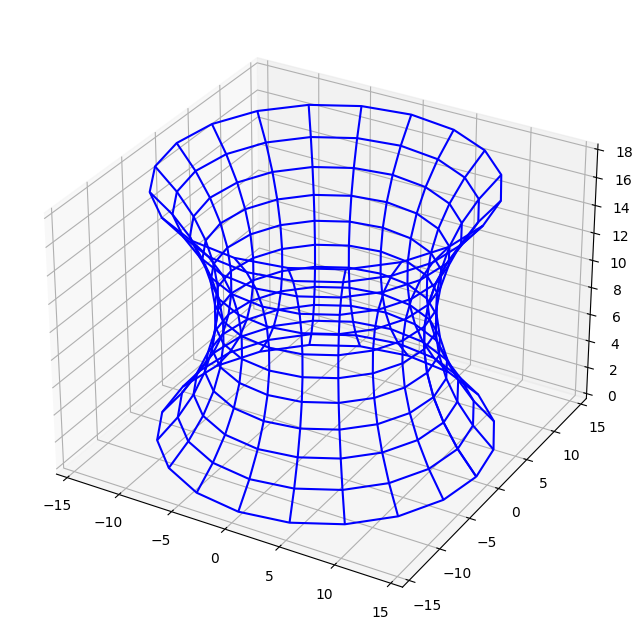

In [ ]:
# Running a demo and plotting the minimal surface.

demo_opt_val, demo_vertices = get_minimal_area(0.0, 18, 14.0, 14.0, 10, 20)


pyplot_axes = pyplot.axes(projection='3d')
pyplot_axes.plot_wireframe(demo_vertices[..., 0],
                           demo_vertices[..., 1],
                           demo_vertices[..., 2],
                           color='blue')

## Let us improve this by adding fast gradients.

This notebook already has the code for the main body,
but what is missing (exercise!) is the gradient of Heron's
triangle-area formula.

In [ ]:
def grad_heron_area(d1, d2, d3, s_output):
  """Computes the gradient for `heron_area`."""
  # TODO: Document this properly!
  # s_output is the sensitivity of the final result of the computation
  # where this occurs as an intermediate result on the output of this function.
  # s = (d1 + d2 + d3) * 0.5
  # return numpy.sqrt(s * (s - d1) * (s - d2) * (s - d3))
  raise NotImplementedError('TODO: Implement this! (Participant Exercise)')

### Solution


def grad_total_mesh_area(z1, z2, r1, r2,
                         inner_vertex_radial_deviations,
                         ddd_delta_xyzs_wrapped=(),
                         ):
  """(Partial) gradient for the `total_mesh_area` function's area.

  Args:
    z1: float, z-height of the first ring.
    z2: float, z-height of the 2nd ring.
    r1: float, radius of the first ring.
    r2: float, radius of the 2nd ring.
    inner_vertex_radial_deviations:
      float [num_inner_rings, num_vertices_per-ring] numpy.ndarray-like,
      per inner mesh-vertex, the (signed) distance by which the vertex
      has been moved radially out from the x=y=0 symmetry axis relative to
      a point on the surface of the conical frustum that is the convex hull
      of the circles around x=y=0 specified by (z1, r1) and (z2, r2).

  Returns:
    float [num_inner_rings, num_vertices_per-ring] numpy.ndarray,
    sensitivities of the mesh area on `inner_vertex_radial_deviations`.
  """
  # In this example, we only use the sensitivities on the radial deviations,
  # but for the sake of illustration, we compute the full gradient.
  #
  # Also, for the sake of "sticking to the recipe", this code does not do
  # some obvious simplifications.
  # When reading this code, it might make sense to duplicate the browser tab
  # and use both tabs side-by-side to view forward and reverse code in
  # separate windows.
  #
  # Participant Exercise: Simplify the code further
  # (such as by eliminating s_area_se_ne_nw, etc.).
  z_like = numpy.zeros_like  # Abbreviation
  inner_vertex_radial_deviations = numpy.asarray(inner_vertex_radial_deviations)
  num_inner_rings, num_vertices_per_ring = inner_vertex_radial_deviations.shape
  num_rings = 2 + num_inner_rings  # The fixed 'wire rings'.
  rs = numpy.linspace(r1, r2, num_rings)
  s_rs = z_like(rs)
  # Per-vertex z-coordinates.
  zs = numpy.tile(numpy.linspace(z1, z2, num_rings)[:, numpy.newaxis],
                  [1, num_vertices_per_ring])
  s_zs = z_like(zs)
  vertex_radial_deviations = numpy.pad(
      inner_vertex_radial_deviations, [(1, 1), (0, 0)])
  s_vertex_radial_deviations = z_like(vertex_radial_deviations)
  # This is just a constant that only depends on the discrete parameter
  # `num_vertices_per_ring` - no need to keep track of a sensitivity here.
  xys_unscaled_complex = numpy.exp(
      1j * numpy.linspace(0, 2 * numpy.pi, num_vertices_per_ring + 1))[:-1]
  xys_scaled_complex = xys_unscaled_complex[numpy.newaxis, :] * (
      rs[:, numpy.newaxis] + vertex_radial_deviations)
  s_xys_scaled_complex = z_like(xys_scaled_complex)
  xyzs = (  # shape [num_rings, num_vertices_per_ring, 3]
      numpy.stack([xys_scaled_complex.real,
                   xys_scaled_complex.imag,
                   zs],
                  axis=-1))
  s_xyzs = z_like(xyzs)
  xyzs_wrapped = numpy.concatenate([xyzs, xyzs[:, :1, :]], axis=1)
  s_xyzs_wrapped = z_like(xyzs_wrapped)
  # There is a 1-to-1 mapping between every point not on the z2-ring and
  # non-planar 4-plaquettes made of two triangles.
  # The four relevant points are:
  # "here" == "SW",
  # "up" (as a shorthand for "towards z2") == "NW",
  # "ccw" (as a shorthand for "next-w.r.t. increasing angle") == "SE",
  # and "ccw-up" == "NE".
  p_sw = xyzs_wrapped[:-1, :-1, :]; s_p_sw = z_like(p_sw)
  p_nw = xyzs_wrapped[1:, :-1, :]; s_p_nw = z_like(p_nw)
  p_se = xyzs_wrapped[:-1, 1:, :]; s_p_se = z_like(p_se)
  p_ne = xyzs_wrapped[1:, 1:, :]; s_p_ne = z_like(p_ne)
  # Here, we introduce extra intermediate quantities which become the
  # arguments of numpy.linalg.norm() below.
  # "We want to remember every intermediate quantity."
  p_sw_nw = p_sw - p_nw; s_p_sw_nw = z_like(p_sw_nw)
  p_sw_se = p_sw - p_se; s_p_sw_se = z_like(p_sw_se)
  p_se_ne = p_se - p_ne; s_p_se_ne = z_like(p_se_ne)
  p_ne_nw = p_ne - p_nw; s_p_ne_nw = z_like(p_ne_nw)
  p_se_nw = p_se - p_nw; s_p_se_nw = z_like(p_se_nw)
  d_sw_nw = numpy.linalg.norm(p_sw_nw, axis=-1); s_d_sw_nw = z_like(d_sw_nw)
  d_sw_se = numpy.linalg.norm(p_sw_se, axis=-1); s_d_sw_se = z_like(d_sw_se)
  d_se_ne = numpy.linalg.norm(p_se_ne, axis=-1); s_d_se_ne = z_like(d_se_ne)
  d_ne_nw = numpy.linalg.norm(p_ne_nw, axis=-1); s_d_ne_nw = z_like(d_ne_nw)
  d_se_nw = numpy.linalg.norm(p_se_nw, axis=-1); s_d_se_nw = z_like(d_se_nw)
  area_sw_se_nw = heron_area(d_sw_se, d_se_nw, d_sw_nw)
  s_area_sw_se_nw = z_like(area_sw_se_nw)
  area_se_ne_nw = heron_area(d_se_ne, d_ne_nw, d_se_nw)
  s_area_se_ne_nw = z_like(area_se_ne_nw)
  # Forward code ended with:
  # return xyzs_wrapped, area_sw_se_nw.sum() + area_se_ne_nw.sum()
  # We are merely interested in the sensitivity of the 2nd tuple entry
  # (the area) on input parameters.
  area = area_sw_se_nw.sum() + area_se_ne_nw.sum()
  s_area_se_ne_nw += 1
  s_area_sw_se_nw += 1
  s1_d_se_ne, s1_d_ne_nw, s1_d_se_nw = grad_heron_area(
      d_se_ne, d_ne_nw, d_se_nw, s_area_se_ne_nw)
  # Here, we are adding the gradients we received from grad_heron_area
  # to our sensitivity-accumulators.
  # There is an obvious improvement opportunity here:
  # Re-write `grad_heron_area` in such a way that it receives our sensitivity-
  # accumulator arrays and directly increments the sensitivities in these
  # arrays, avoiding the copying.
  s_d_se_ne += s1_d_se_ne
  s_d_ne_nw += s1_d_ne_nw
  s_d_se_nw += s1_d_se_nw
  s1_d_sw_se, s1_d_se_nw, s1_d_sw_nw = grad_heron_area(
      d_sw_se, d_se_nw, d_sw_nw, s_area_sw_se_nw)
  s_d_sw_se += s1_d_sw_se
  s_d_se_nw += s1_d_se_nw
  s_d_sw_nw += s1_d_sw_nw
  # Backpropagating through numpy.linalg.norm():
  # d{norm(vector)} / d{vector} = {vector}/{norm(vector)}
  s_p_sw_nw += p_sw_nw * (s_d_sw_nw / d_sw_nw)[:, :, numpy.newaxis]
  s_p_sw_se += p_sw_se * (s_d_sw_se / d_sw_se)[:, :, numpy.newaxis]
  s_p_se_ne += p_se_ne * (s_d_se_ne / d_se_ne)[:, :, numpy.newaxis]
  s_p_ne_nw += p_ne_nw * (s_d_ne_nw / d_ne_nw)[:, :, numpy.newaxis]
  s_p_se_nw += p_se_nw * (s_d_se_nw / d_se_nw)[:, :, numpy.newaxis]
  s_p_sw += s_p_sw_nw
  s_p_nw -= s_p_sw_nw
  s_p_sw += s_p_sw_se
  s_p_se -= s_p_sw_se
  s_p_se += s_p_se_ne
  s_p_ne -= s_p_se_ne
  s_p_ne += s_p_ne_nw
  s_p_nw -= s_p_ne_nw
  s_p_se += s_p_se_nw
  s_p_nw -= s_p_se_nw
  s_xyzs_wrapped[:-1, :-1, :] += s_p_sw
  s_xyzs_wrapped[1:, :-1, :] += s_p_nw
  s_xyzs_wrapped[:-1, 1:, :] += s_p_se
  s_xyzs_wrapped[1:, 1:, :] += s_p_ne
  if 'DDD':
    for delta, coords in ddd_delta_xyzs_wrapped:
      print(f'DDD s_xyzs_wrapped[{coords}] = {s_xyzs_wrapped[coords]}')
  # Forward code:
  # xyzs_wrapped = numpy.concatenate([xyzs, xyzs[:, :1, :]], axis=1)
  s_xyzs += s_xyzs_wrapped[:, :-1, :]
  s_xyzs[:, :1, :] += s_xyzs_wrapped[:, -1:, :]
  # Forward code:
  # xyzs = (  # shape [num_rings, num_vertices_per_ring, 3]
  #     numpy.stack([xys_scaled_complex.real,
  #                  xys_scaled_complex.imag,
  #                  zs],
  #                 axis=-1))
  # Backpropagating gets interesting here, since we get to see 'sensitivity of
  # the end result on the real/imaginary part of a complex quantity'.
  # It so turns out that we have to take the complex conjugate here(!).
  # This is discussed at the end of this notebook.
  s_xys_scaled_complex += s_xyzs[..., 0] - 1j * s_xyzs[..., 1]
  s_zs += s_xyzs[..., 2]
  # Forward code:
  # xys_scaled_complex = xys_unscaled_complex[numpy.newaxis, :] * (
  #     rs[:, numpy.newaxis] + vertex_radial_deviations)
  # The `xys_unscaled_complex` are just "constants" we do not need to backprop
  # into.
  # We perhaps should have introduced the 2nd factor as another intermediate
  # quantity above, with its own sensitivity-accumulator, but since this
  # subexpression is a simple sum that only shows up once, its
  # sensitivity-accumulator only receives a single contribution, so we might
  # just as well define it down here.
  s_rs_plus_radial_deviations = s_xys_scaled_complex * (
      xys_unscaled_complex[numpy.newaxis, :])
  # This is interesting: We just switched over to taking a product of
  # complex sensitivities with a complex number - so we are now in
  # complex-backprop land. Hence, the sensitivity introduced above is
  # complex-valued, but we only want/need the real part here.
  s_rs += s_rs_plus_radial_deviations.real.sum(axis=-1)
  s_vertex_radial_deviations += s_rs_plus_radial_deviations.real
  # This is the most important part of the "full gradient", which we are
  # actually using in our computation.
  # We could proceed to compute the r1/r2/z1/z2-sensitivities for the sake
  # of completeness here. Physically, these would tell us about the force with
  # which a soap film of constant surface tension would try to bring the
  # rings together, respectively squeeze them.
  # (This might be a Participant Exercise for very motivated participants,
  # since backprop through numpy.linspace() will require a bit of thinking here,
  # and potentially also debugging - so this could get somewhat frustrating
  # when tried as an early exercise. If, however, we do not do this, then
  # there also is no need to compute s_rs above.)
  s_inner_vertex_radial_deviations = s_vertex_radial_deviations[1:-1, :]
  return s_inner_vertex_radial_deviations


### Hints for implementing grad_heron_area

(Not shown in the transcript, only in the accompanying notebooks.)

BEGIN_EXCLUDE_FROM_NOTES

In [ ]:
# HINT #1

# Step 1: Re-write code to remember all intermediate quantities.
def grad_heron_area_hint1(d1, d2, d3, s_output):
  """Computes the gradient for `heron_area`."""
  perimeter = d1 + d2 + d3
  s = 0.5 * perimeter
  delta_s_d1 = s - d1
  delta_s_d2 = s - d2
  delta_s_d3 = s - d3
  prod_ssd1 = s * delta_s_d1
  prod_sd2sd3 = delta_s_d2 * delta_s_d3
  prod = prod_ssd1 * prod_sd2sd3
  ret = prod ** .5
  return ret

# Step 2: Add backprop-code.
# For used-once-only intermediate quantities, we do not need to zero-initialize
# sensitivity-accumulators, but can initialize them with the only contribution
# they receive.
def grad_heron_area(d1, d2, d3, s_output):
  """Computes the gradient for `heron_area`."""
  s_d1 = numpy.zeros_like(d1)
  s_d2 = numpy.zeros_like(d2)
  s_d3 = numpy.zeros_like(d3)
  perimeter = d1 + d2 + d3
  ...


In [ ]:
# HINT #2

def get_grad_heron_solution():
  # De-obfuscates the embedded solution.
  # (No need to understand this - black magic ahead.)
  import bz2, base64
  data = b'QlpoOTFBWSZTWQ51adYAABZfgAAQWH/6GikADAD/7/+wQAJwXCQbDIqZoZE0wEZA0aNAGmg0yImmpqbRtUyaGQaGgbUAYDRkNBhANANNAACTUiCNGp6SPRPU0yAAD1NGOvHPvixkw0Tsocjmc3wic1NSQtoQTzKw4/DuA0EMzYsGphBoL9MYkRKIiIaTu7BJ8p9YXO7UJtSiitQ8mEk7vlYAUltp+7hpO66buhi2utzJ2Oyp5HbhHQc7wJ0vdVdknZKKHtrKRmzEBy2ALOCQSCUWVEkkkkQOE9g96vpyrnjwG/BDemBIYhG4oZLrrlsohIBYxgRGaHibNumdyb1GMF5hAUBhCCgB2hlUOHPCEPHyUaYi80D2G0hDNgTmSFADfs5kg7vtpPyfj5dfMn6MOvAp47ca4306E2yyNeWXCDQNShj2FWYLCqKsAqVTUqIiLaxeGm4A+77cMlVEQRURImLnM7AVI9kBNNnqMcWFDIEBIa/VGTeCkj4QBXnANBQSMjlEEChTkk/JfyCVyLTaQ8Da0PpWKhopr2tuNod3hyDTUzJDQdcydM4ONypWWBYrEte9w24ZSQ0652OWThb9n9zqoWDXsNeNBvEYjFGMH1bjpC+MMY9xhyAwkq8naPgSCKGUm/GIMHlfy1q8MIxYMRGCKsDEGEO8CwHwAz34bYAZ2S63yzt3khr55Eyw8dN4CzwnugVlcJ/1oA6rCtuJB1C8WDS0HWFSgExLkB/F3JFOFCQDnVp1gA=='
  with open('grad_heron_aux.py', 'wt') as h:
    h.write(bz2.decompress(base64.b64decode(data)).decode('utf-8'))
  import grad_heron_aux
  grad_heron_aux.numpy = numpy
  return grad_heron_aux.grad_heron_area

# Uncommenting this line makes the notebook use the embedded obfuscated solution:
# grad_heron_area = get_grad_heron_solution(); print('Loaded solution:', grad_heron_area)

# Additionally uncommenting this line shows the solution's code:
# !cat grad_heron_aux.py


END_EXCLUDE_FROM_NOTES

### Testing it out

Let us actually try to gain some confidence in our gradient before we use it.

Our strategy: Define a random-but-reproducibly-so point and direction, define a 1-parameter function that walks along that direction, compare backprop-gradient with Taylor expansion.


In [ ]:
def verify_grad_mesh_area(rng_seed=0):
  # Let us get a seeded guaranteed-reproducible-even-across-numpy-versions
  # random number generator.
  rng = numpy.random.RandomState(seed=rng_seed)
  # We are taking somewhat generic values for the problem.
  z1, z2, r1, r2 = -0.5, 2.0, 20.0, 21.0
  num_inner_rings, num_vertices_per_ring = 5, 10
  x0 = rng.normal(size=(num_inner_rings, num_vertices_per_ring), scale=0.1)
  x_dir_unnormalized = rng.normal(size=(num_inner_rings, num_vertices_per_ring))
  x_dir = x_dir_unnormalized / numpy.linalg.norm(x_dir_unnormalized)
  def f_area(s):
    _, area = vertices_and_total_mesh_area(z1, z2, r1, r2, x0 + s * x_dir)
    return area
  fprime_area_numerical = numerical_derivative(f_area)
  grad_at_x0 = grad_total_mesh_area(z1, z2, r1, r2, x0)
  return fprime_area_numerical(0), grad_at_x0.ravel().dot(x_dir.ravel())

# We compare 10 randomly picked positions and directions.
# If these gradients match, this provides rather strong validation.
for seed in range(10):
  print('seed:', seed, verify_grad_mesh_area(rng_seed=seed))

# Let us also quickly ad-hoc check our "Heron's area formula" gradient
# (To better illustrate this).
print('Heron-Check: area', heron_area(3.,4.,4.5),
      'numerical_grad[2]', (heron_area(3.,4.,4.5 + 1e-7) -
                            heron_area(3.,4.,4.5)) / 1e-7 ,
      'backprop_grad_full', grad_heron_area(3.,4.,4.5,1))

In [ ]:
# The same demo as before - but this time, we report every call,
# rather than every 1000th.

demo2_opt_val, demo2_vertices = get_minimal_area(
    0.0, 18, 14.0, 14.0, 10, 20,
    report_every_n_calls=1,
    grad_area=grad_total_mesh_area)


pyplot2_axes = pyplot.axes(projection='3d')
pyplot2_axes.plot_wireframe(demo2_vertices[..., 0],
                            demo2_vertices[..., 1],
                            demo2_vertices[..., 2],
                            color='black')

# Participant Exercise:
# Compare total optimization run time for the previous and this exercise.

# Participant Exercise:
# How much finer can we make the discretization?
# At how many degrees of freedom does this get "high effort"?

# Participant Exercise:
# Put a numerical bug(!) into the gradient-of-total-area function in some
# random place (such as: change a sign from + to -)
# and check how this then impacts optimization here.

# Participant Exercise:
# Adjust the code to allow other boundary shapes than the edges of a symmetric
# conical frustum. (Such as: using different semimajor axes,
# adding an in-plane displacement, etc.)

# A first Machine Learning Example

Let us actually use what we learned to build and train an extremely simple machine learning model without using any ML or backpropagation framework library (apart from using TensorFlow to load the example data).

For quite a few years, the "fruit fly" / "hydrogen problem" / "N=4 SYM" type system used for ML was handwritten digit classification using the "MNIST" dataset of digitized handwriting samples - tens of thousands of digits written by real people and digitized to 28x28 pixel grayscale resolution, with center-of-gravity for the ink shifted-to-center and some other such normalizations.

One of the big problems with MNIST is that it is "too easy to learn". Nowadays, it is only used rarely, and mostly in the context of unusual architectures or applications. Nevertheless, knowing about this dataset is important background for reading some of the older foundational papers.

Let us build a very primitive classifier that tells us "Yes" or "No", depending on whether or not it thinks the digit is an 8. We will do this not on 28x28 images, but on images downsampled to 14x14. Also, we will only use 1000 example images for training - which everybody would recognize in these days as "being way too few examples to meaningfully do ML".

But first, let us load and inspect this popular dataset.

In [ ]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


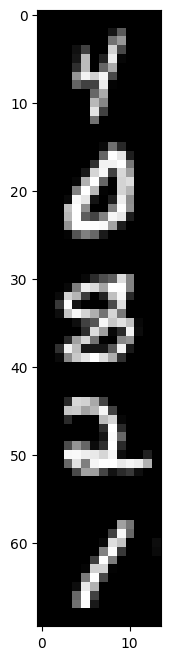

[4 0 8 2 1]
Number of 8-digits: 209


In [ ]:
# We actually take 4000 image samples from the "MNIST training set"
# and split them into two sets, the "even indices" and "odd indices",
# where we use one of these as our reduced-size training set,
# and the other one to assess how well our model manages to handle
# input it has never seen before.
images_and_labels_all = list(ds_train.take(4000).as_numpy_iterator())
images_and_labels_training = images_and_labels_all[::2]
images_and_labels_test = images_and_labels_all[1::2]

def as_14x14(data):
  """Maps a [..., 28, 28]-array to a [..., 14, 14]-array by 2x2-averaging."""
  data = numpy.asarray(data)
  shape = data.shape
  return data.reshape(shape[:-3] + (14, 2, 14, 2)).mean(axis=(-1, -3))

# Raw data use unsigned 8-bit grayscale values (integers in [0..255]).
# Rescale to floats in 0..1 and stack them up into a [num_examples, 28, 28]
# array.
images_training = numpy.stack(
    [image / 255.0 for image, label in images_and_labels_training],
    axis=0)
labels_training = numpy.array(
    [label for image, label in images_and_labels_training])
images_test = numpy.stack(
    [image / 255.0 for image, label in images_and_labels_test],
    axis=0)
labels_test = numpy.array(
    [label for image, label in images_and_labels_test])

pyplot.imshow(as_14x14(images_training[:5]).reshape(-1, 14) , cmap='gray')
pyplot.show()
print(labels_training[:5])

# Let us see how many 8-digits there are in this sample:
print('Number of 8-digits:', sum(x==8 for x in labels_training))

Overall, we have 1000 training images which we will downscale to 14x14=196 brightness float-values (one per pixel). So, our reduced-size dataset consists of 39200 floating point numbers in total.

There are many different approaches one could try to come up with a digit-8 classifier, such as for example:

 1. Write tailored code that exploits special properties of the digit "8",
    such as:
    
    "Classify this digit as 8 if and only if there are three
    separate non-inked regions".

 2. Consider each example as a point in high-dimensional (D=$14^2=196$)
    space and, for a given input, look at the classifications of the
    10 nearest-neighbor examples.

We will look into these later. Approach (1.) was used somewhat widely in the 90s for problems "where the best we can do is ad hoc heuristics". ML follows the ideas presented in Turing's 1948 paper "[Intelligent Machinery](https://hashingit.com/elements/research-resources/1948-intelligent-machinery.pdf)": "can we use examples to fine-tune parameters of a general architecture via optimization, in order to maximize classifier performance (w.r.t. the capabilities of the given architecture)?"

```
  A great positive reason for believing in the possibility of making thinking
  machinery is the fact that it is possible to make machinery to imitate any
  small part of a man. That the microphone does this for the ear, and the
  television camera for the eye are commonplaces. (...) Here we are chiefly
  interested in the nervous system. We could produce fairly accurate electrical
  models to copy the behaviour of nerves, but there seems very little point in
  doing so. It would be rather like (...) cars which walked on legs (...).

  (...)

  If we are trying to produce an intelligent machine, and are following the
  human model as closely as we can, we should begin with a machine with very
  little capacity to carry out elaborate operations or to react in a disciplined
  manner to orders (taking the form of inference). Then by applying appropriate
  inference, mimicking education, we should hope to modify the machine until it
  could be relied on to produce definite reactions to certain commands.

```

What is the "dumbest" possible idea we can come up with here that still looks somewhat reasonable? We want a function that maps input data, as a
${\mathbb R}^{14\times 14}$ vector, to some sort of "accumulated evidence that we are looking at a number 8 digit".

The structurally simplest functions we can think of doing something like this are linear (rather, affine, i.e. "with offset" functions. So, we are looking for a linear function that we want to output some large positive number if we are looking at a digit 8 and some large negative number if not. But what would our objective function for numerical minimization then look like?

Right now, our focus is on "numerical optimization" and "doing everything from scratch, no ML frameworks allowed", so we will have to come back to this question later in the course. Here, we will only use two ideas - to be justified later.

  1. For every given input image, we want to map the accumulated evidence to a
     "this is how I, the classifier, would bet" (Bayesian) probability for
     the example to have a positive (binary classification) label.
     
     It so turns out that the appropriate function to do this is the
     "sigmoid function" $f(x)=1/(1+\exp(k-x))$, which we of course also
     are familiar with in the context of the thermodynamics of a 2-state
     system. Here, the offset is a tunable/"learnable" parameter.

  2. Given probabilities and ground truth labels, we need to produce a
     "how far are we off on these examples" score. Here, we go with a
     smooth variant of the basic idea that "for misclassifications, we want
     to count the number of interval bisections that tell us how far off
     our probability estimate was". So, if we have a label=True case where
     we say "p=6.25% this is True", this needs "3 bisecting binary questions"
     (50% -> 25% -> 12.5% -> 6.25%), while if we say "p=25%", this needs
     "1 bisecting binary question" so is only 1/3 as bad overall in terms
     of information content.


Let's build this.

In [ ]:
def get_digit8_classifier(training_images,
                          training_labels,
                          seed=0,
                          maxiter=10_000,
                          debug_print_every_n_calls=100):
  """Returns a pair (classifier_parameters, classifier) for detecting 8-s.

  Args:
    training_images:
      [0..1]-float [num_images, num_rows, num_columns]-array-like,
      the training dataset.
    training_labels: [num_images]-array-like, array of ground truth labels
      (0-9) for the images in `training_images`.
    seed: Random number generator seed.
    maxiter: Maximal number of iterations for the BFGS-minimizer.
    debug_print_every_n_calls: Controls how often we print progress information.

  Returns:
    A pair of `(classifier_parameters_vector, classifier_callable)`,
    where calling `classifier_callable` on a
    [num_images_to_classify, num_rows, num_columns]-array-like collection
    of image data returns a corresponding vector of best-estimate probabilities
    for the image to show an 8-digit.
  """
  training_images = numpy.asarray(training_images)
  training_labels = numpy.asarray(training_labels)
  label_positive = training_labels == 8
  def get_prob(params, images):
    stencil_params = params[:-1]
    offset = params[-1:]  # A [1]-vector, for broadcasting.
    evidence = numpy.einsum('ix,x->i',
                            images.reshape(images.shape[0], -1),
                            stencil_params)
    return 1 / (1 + numpy.exp(offset-evidence))
  num_calls = 0
  def get_quality_score(params):
    nonlocal num_calls
    prob = get_prob(params, training_images)
    # The 1e-12 offsets help handling cases where exp(-evidence) is numerically
    # zero due to underflow. This avoids running into log(0), which produces
    # NaN intermediate results.
    result = -(label_positive * numpy.log(1e-12 + prob) +
               (1 - label_positive) * numpy.log(1+1e-12-prob)).mean()
    num_calls += 1
    if (debug_print_every_n_calls is not None and
        num_calls % debug_print_every_n_calls == 0):
      print(f'N={num_calls:6d}: score={result:16.10f}')
    return result
  # BEGIN Gradient code
  # We want the sensitivity of `prob` on parameters.
  def get_s_prob(params, images, s_result):
    stencil_params = params[:-1]
    offset = params[-1:]  # A [1]-vector, for broadcasting.
    s_params = numpy.zeros_like(params)
    evidence = numpy.einsum('ix,x->i',
                            images.reshape(images.shape[0], -1),
                            stencil_params)
    exp_neg_evidence = numpy.exp(offset-evidence)
    denom = 1 + exp_neg_evidence
    result = 1 / denom
    #
    # s_denom = -s_result / (denom * denom)
    s_exp_neg_evidence = -s_result / (denom * denom)
    s_evidence = s_exp_neg_evidence * (-exp_neg_evidence)
    s_offset = -s_evidence.sum(keepdims=True)
    s_stencil_params = numpy.einsum('ix,i->x',
                                   images.reshape(images.shape[0], -1),
                                   s_evidence)
    return numpy.concatenate([s_stencil_params, s_offset])
  def get_s_quality_score(params):
    prob = get_prob(params, training_images)
    s_prob = numpy.zeros_like(prob)
    part1 = label_positive * numpy.log(1e-12 + prob)
    part2 = (1-label_positive) * numpy.log(1+1e-12-prob)
    result = -(part1 + part2).mean()
    #
    s_part1 = -1 / len(part1)
    s_part2 = -1 / len(part2)
    s_prob += s_part1 * label_positive / (1e-12 + prob)
    s_prob -= s_part2 * (1-label_positive) / (1+1e-12-prob)
    return get_s_prob(params, training_images, s_prob)
  # END Gradient code
  rng = numpy.random.RandomState(seed=seed)
  # Model parameters are: 14x14 per-pixel-evidence weights, plus one overall
  # evidence-offset.
  v_start = rng.normal(size=14*14 + 1, scale=1e-2)
  opt = scipy.optimize.fmin_bfgs(get_quality_score,
                                 v_start,
                                 fprime=get_s_quality_score,
                                 gtol=1e-10,
                                 maxiter=maxiter)
  return opt, lambda images: get_prob(opt, images)

# Quite likely, training/optimization will stop here once we run into
# exp() overflow - but even with optimization not proceeding to the minimum,
# we do get a somewhat useful classifier.
opt_params, classifier = get_digit8_classifier(as_14x14(images_training),
                                               labels_training)


N=   100: score=    0.0747413554
N=   200: score=    0.0651305360
N=   300: score=    0.0620802156
N=   400: score=    0.0607213317
N=   500: score=    0.0600792142
N=   600: score=    0.0596360551
N=   700: score=    0.0591480792
N=   800: score=    0.0588810554
N=   900: score=    0.0585761021
N=  1000: score=    0.0580431305
N=  1100: score=    0.0578176706
N=  1200: score=    0.0576444457
N=  1300: score=    0.0574787213
N=  1400: score=    0.0573991570
N=  1500: score=    0.0573255619
N=  1600: score=    0.0572122781
N=  1700: score=    0.0569957265


<ipython-input-68-cbe0ab0e1b3e>:63: RuntimeWarning: overflow encountered in multiply
  s_exp_neg_evidence = -s_result / (denom * denom)


         Current function value: 0.056684
         Iterations: 1751
         Function evaluations: 1768
         Gradient evaluations: 1756


<ipython-input-68-cbe0ab0e1b3e>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + numpy.exp(offset-evidence))
<ipython-input-68-cbe0ab0e1b3e>:58: RuntimeWarning: overflow encountered in exp
  exp_neg_evidence = numpy.exp(offset-evidence)
<ipython-input-68-cbe0ab0e1b3e>:64: RuntimeWarning: invalid value encountered in multiply
  s_evidence = s_exp_neg_evidence * (-exp_neg_evidence)
<ipython-input-68-cbe0ab0e1b3e>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + numpy.exp(offset-evidence))
<ipython-input-68-cbe0ab0e1b3e>:58: RuntimeWarning: overflow encountered in exp
  exp_neg_evidence = numpy.exp(offset-evidence)
<ipython-input-68-cbe0ab0e1b3e>:63: RuntimeWarning: overflow encountered in multiply
  s_exp_neg_evidence = -s_result / (denom * denom)
<ipython-input-68-cbe0ab0e1b3e>:64: RuntimeWarning: invalid value encountered in multiply
  s_evidence = s_exp_neg_evidence * (-exp_neg_evidence)


We do observe that optimization failed here since we were not appropriately careful implementing our objective function in a way that does not readily run into numerical pathologies. It is perhaps useful to show that such things can and do happen, and thinking about how to avoid numerical cancellation, blow-ups etc. is generally important when implementing machine learning components.

We could fix this here, but do not really have to - optimization, even as it technically failed to complete, has already produced a somewhat useful performance-enhancement. Had we used a loss function from a ML library, this point would have been addressed in its implementation.

N=  9: label=1, prob=0.9785949016 X
N= 31: label=8, prob=0.0017661758 X
N= 97: label=8, prob=0.4151601095 X
N=129: label=6, prob=0.6621850765 X
N=163: label=2, prob=0.7174619928 X
N=169: label=6, prob=0.5418635124 X
N=170: label=8, prob=0.0022988911 X
N=184: label=8, prob=0.3697129140 X
N=187: label=8, prob=0.2133721492 X
N=212: label=8, prob=0.0934954688 X
N=227: label=8, prob=0.0000000000 X
N=228: label=8, prob=0.0000000000 X
N=262: label=8, prob=0.1821384720 X
N=282: label=3, prob=0.9977189467 X
N=289: label=5, prob=0.9264995652 X
N=290: label=8, prob=0.0000002562 X
N=291: label=8, prob=0.0000000032 X
N=293: label=8, prob=0.0000000000 X
N=307: label=8, prob=0.0574443067 X
N=318: label=9, prob=0.7543842702 X


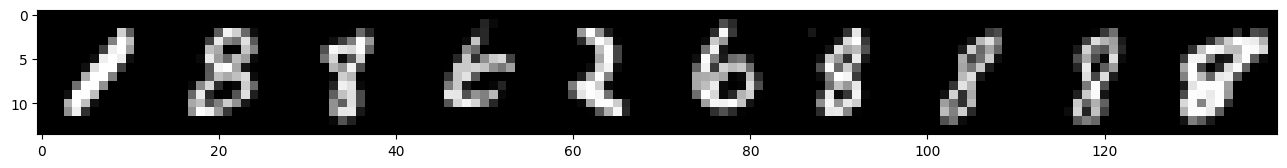

121 [1, 8, 8, 6, 2, 6, 8, 8, 8, 8, 8, 8, 8, 3, 5, 8, 8, 8, 8, 9, 0, 4, 8, 0, 8, 8, 0, 2, 9, 1, 0, 1, 2, 8, 8, 5, 8, 0, 8, 8, 8, 2, 5, 2, 8, 4, 2, 8, 4, 5, 8, 6, 7, 4, 4, 2, 9, 8, 8, 3, 8, 0, 8, 8, 8, 8, 7, 5, 5, 8, 9, 0, 1, 8, 5, 8, 8, 8, 2, 4, 8, 8, 8, 7, 2, 8, 4, 5, 5, 8, 1, 8, 8, 8, 8, 8, 5, 2, 8, 8, 8, 2, 8, 8, 8, 2, 8, 8, 8, 8, 5, 8, 1, 8, 8, 4, 5, 8, 5, 4, 2]

###
Always-guessing-not-8 would make 203 misclassifications (10.2%).
We made 121 misclassifications (6.0%).
With sigma = sqrt(2000 * 0.1 * 0.9) = 13.42, this is at
6.11 sigma for the baseline classifier.


In [ ]:
# Let us actually try out our classifier on some of our test images:
num_test = 2000
max_num_bad_to_show = 20
num_bad_shown = 0
images_test_14x14 = as_14x14(images_test[:num_test])
classified_test_images = classifier(images_test_14x14)
bad_labels_images = []
for n, prob, label_test in zip(range(num_test),
                               classified_test_images,
                               labels_test):
  is_bad = (prob > 0.5) != int(label_test == 8)
  # Disable this check to print all classifications.
  if is_bad and num_bad_shown < max_num_bad_to_show:
    num_bad_shown += 1
    print(f'N={n:3d}: label={label_test}, '
          f'prob={prob:.10f} {"X" if is_bad else " "}')
  if is_bad:
    bad_labels_images.append((label_test, images_test_14x14[n]))
pyplot.imshow(
    numpy.concatenate(
        [image for label, image in bad_labels_images[:10]],
        axis=1),
    cmap='gray')
pyplot.show()
bad_labels = [label for label, image in bad_labels_images]

print(len(bad_labels), bad_labels)

# Let us also check if we are actually better than always-guessing-"not an 8".
num_test_8s = (labels_test[:num_test] == 8).sum()
sigma = (num_test * 0.1 * 0.9)**.5
print('\n###\n'
      f'Always-guessing-not-8 would make {num_test_8s} misclassifications '
      f'({100 * num_test_8s / num_test:.1f}%).\n'
      f'We made {len(bad_labels)} misclassifications '
      f'({100 * len(bad_labels) / num_test:.1f}%).\n'
      f'With sigma = sqrt({num_test} * 0.1 * 0.9) = {sigma:.2f}, this is at\n'
      f'{abs(len(bad_labels) - num_test_8s) / sigma:.2f} sigma for the '
      f'baseline classifier.')


## Participant Exercises

* On the MNIST dataset, humans are observed to have a
  "which digit is it" classification error rate in the ballpark of 2-3%.
  Change the code to load 500 examples and visualize them in a 50x10 grid.
  Hand-classify them and compare your classifications with the "ground truth"
  labels. Is this claimed human error rate plausible?

* Above, we introduced an 'offset'. Does this parameter actually have an
  impact on performance? Replace `offset` with `0 * offset` in the code above
  to check this.

* Find out if the MNIST training dataset (50_000 examples) contains any
  exact duplicate images. (This might need some creativity.)

* Change the above code to only see examples where the ground truth label
  is "1" or "2", and build a binary "is it a digit 1?" classifier.
  Is it much better than random guessing? [It should be!]

* Can you fix the "numerical overflow" problem observed above?

One way to think about such classification problems is as follows: We decided to believe in the existence of two smooth ${\mathbb R}^{14\times 14}\mapsto{\mathbb R}$ probability distribution functions which describe the probability-density for "a human asked to write a digit 1 (respectively, 2) will produce something that looks like this". We do not know what they look like, but we can sample thousands of the examples from these probability distributions - which we did.

When we classify a never-seen-before example, we try to use what we have seen to estimate the likelihood ratio "is this a 1" vs. "is this a 2", and make a call based on this estimate.

Let us try a radically different approach that does not really use any "learning": For a given not-observed-before input, we determine the euclidean distance to each training set example, and look at the N closest neighbors and their classes.

In [ ]:
def get_neighborhood_analyzer(images_training, labels_training):
  images_training = (
      numpy.asarray(images_training).reshape(images_training.shape[0], -1))
  labels_training = numpy.asarray(labels_training)
  def get_neighborhood(image_new, num_neighbors=10):
    image_new = numpy.asarray(image_new).reshape(1, -1)
    distances = numpy.linalg.norm(images_training - image_new, axis=-1)
    sorted_indexed_distances = sorted(enumerate(distances), key=lambda nd: nd[1])
    return [(dist, labels_training[index])
            for index, dist in sorted_indexed_distances[:num_neighbors]]
  return get_neighborhood

analyzer = get_neighborhood_analyzer(as_14x14(images_training), labels_training)
for n in range(20):
  analyzed = [(numpy.round(dist, 2), label)
              for dist, label in analyzer(as_14x14(images_test[n]))]
  print(n, labels_test[n], analyzed)

# Participant Exercise:
# Build a 1-out-of-10 classifier out of such a neighborhood-analyzer by
# doing some (distance-weighted?) counting of the labels of the 10 (or 100)
# nearest neighbors in the training dataset.


0 1 [(0.6, 1), (0.94, 1), (0.96, 1), (1.0, 1), (1.15, 1), (1.17, 1), (1.21, 1), (1.21, 1), (1.22, 1), (1.28, 1)]
1 7 [(2.24, 7), (2.25, 7), (2.35, 7), (2.37, 7), (2.39, 7), (2.39, 7), (2.44, 7), (2.47, 7), (2.47, 9), (2.49, 7)]
2 1 [(1.06, 1), (1.13, 1), (1.2, 1), (1.24, 1), (1.24, 1), (1.24, 1), (1.3, 1), (1.32, 1), (1.34, 1), (1.36, 1)]
3 7 [(1.57, 7), (1.8, 7), (1.8, 7), (1.86, 7), (2.0, 7), (2.16, 7), (2.26, 7), (2.36, 7), (2.36, 7), (2.38, 7)]
4 6 [(1.55, 6), (1.69, 6), (1.72, 6), (1.92, 6), (1.96, 6), (1.98, 6), (2.01, 6), (2.01, 6), (2.16, 6), (2.17, 6)]
5 4 [(2.19, 4), (2.28, 4), (2.67, 4), (2.84, 4), (2.89, 5), (2.95, 4), (2.99, 9), (3.05, 4), (3.07, 4), (3.08, 4)]
6 7 [(1.89, 9), (1.92, 7), (1.92, 7), (1.94, 7), (2.14, 1), (2.16, 7), (2.22, 9), (2.23, 7), (2.24, 7), (2.26, 9)]
7 3 [(1.86, 3), (2.27, 3), (2.35, 3), (2.45, 3), (2.5, 3), (2.56, 3), (2.58, 3), (2.6, 3), (2.62, 3), (2.7, 3)]
8 9 [(2.28, 9), (2.4, 9), (2.45, 9), (2.56, 9), (2.56, 3), (2.6, 9), (2.63, 9), (2.67, 9),

Overall, what we have been doing here, especially with this last nearest-neighbors approach, has some smell of "having made many ad-hoc and arbitrary choices". For example, the distribution of brightness-values observed on the training set for a near-center pixel will in general be a rather different one than for a pixel that only very rarely receives ink - and yet, "we treat them all the same w.r.t. measuring distance" - is this actually justified?

Clearly, there are numerous ways to tune and tweak any such ML-ish approach, and (unfortunately) a widely held view in the ML community is that a criterion for publication-worthiness of research is whether it meaningfully manages to improve performance numbers (such as: fraction of correct classifications) on some of the (more or less) widely discussed model problems/datasets. Due to this situation, it can be both very easy to get published in ML but at the same time accept/reject decisions on papers do strongly depend on chance (a large body of articles in need of review naturally impacts the quality of reviews).

It has been said that "ML exists because humans are not good at seeing structure in very high dimensions", and "ML works" because real-world probability distributions may have some subtle structure but in general are not as badly behaved as they could be in principle. In this sense, we can see ML like a "telescope like perception-enhancing tool, but for seeing (coarse) structure in very high dimensions".

So, much of ("supervised", i.e. "ground truth target labels based") Machine Learning is about finding "tight" approximations to high dimensional probability distributions. Depending on how we build our parametric model, we can express only some structural features but not others. For our optimizer-based classifier above, the "language" of likelihood-ratio functions expressible by our ansatz has a lot of extra constraining structure - if we undo the final sigmoid that gives us a probability, we find a function that only linearly depends on the brightness ("ink value") of each pixel. This means especially: If we start from a blank image, then there will be a way to add ink that increases the digit-8-evidence fastest, and along every direction that has a positive scalar product with this one, we will add figure-8-evidence. It might just be that we "hit maximum brightness" on some pixel before we build up any meaningful such evidence. In particular, there is no way to represent any "if these two pixels have ink, that correlation provides us extra evidence" type of information in this overly simple model.
We could of course amend our model, introducing extra (tunable) parameters, that are sensitive to such correlations.

Ultimately, this class of ML applications revolve around:
"If we get to see examples drawn from a distribution that is not too different from what we obtained the training set from, what can we achieve by trying to maximize the odds of getting our predictions right?" In a way, this essentially statistics-based approach is very different from what one would intuitively call "learning", and this is nicely illustrated by training (i.e. parameter-tuning) a ML model on the training set but then feeding it trivially-transformed input, such as handwritten digits that have been rotated by 90 degrees. Clearly, "learning" is about as much a different notion in ML and human education context as "force" has different meanings in physical and
colloquial context.

This "most likely the thing we want according to the background distribution" approach can have quite interesting - and sometimes problematic - consequences, especially if examples codify some form of "established bad habits" which then get baked into models. On Google Shopping, it is no problem to buy "two inch nails", but basically impossible to buy "nine inch nails", since that also happens to be the name of a popular band.

---

The classifier we built is simple enough to do one more thing with it: Let us actually plot the per-pixel-digit-8-evidence-weights themselves, reshaped to 14x14. This tells us "the direction in ${\mathbb R}^{14\times 14}$ along which evidence-for-digit-8 increases fastest".

[[0.02, 0.0, 0.01, 0.02, 0.01, -0.09, -0.02, -0.12, -0.04, -0.0, 0.0, 0.01, 0.01, 0.0],
 [0.0, 0.0, -0.24, -3.42, -40.18, -120.73, -574.21, 6.38, -6.84, 0.56, -25.44, -23.46, -0.09, -0.0],
 [0.02, -0.09, -2.5, -71.73, -4.82, 7.0, 0.16, -3.4, 0.65, -2.22, -0.84, -1.58, 5.17, -132.14],
 [-0.02, -22.14, -41.19, 6.13, -3.71, 0.8, -2.13, 0.06, 0.97, 0.51, 0.5, -1.09, -6.02, -14.92],
 [-0.01, -30.91, 11.39, -4.16, 3.03, 0.89, 1.81, -9.05, 1.41, -0.3, 0.76, 2.18, -4.29, -70.48],
 [-0.06, -9.57, -1.2, 0.01, -0.76, 3.76, 1.43, -0.01, -2.69, 0.06, 5.22, 8.11, 5.48, -26.5],
 [0.01, -0.55, -23.04, 8.86, 2.74, -1.91, 7.52, -2.33, 2.5, -0.53, 2.29, -1.14, 3.02, -2.64],
 [0.0, -0.04, -148.09, -15.03, -9.45, 0.45, 2.13, 2.04, 1.23, -6.61, 0.68, -0.97, 6.07, -7.64],
 [-0.01, -0.2, -109.31, -5.99, 7.9, 0.85, 4.81, -1.19, -0.96, -1.11, -2.91, -8.95, 14.29, -1.41],
 [-0.01, -54.86, 1.46, 0.03, -2.59, 4.47, 1.8, -0.76, 1.67, 0.34, 6.12, 3.34, -139.21, -7.2],
 [-0.04, -57.08, -4.11, -1.84, 2.67, -1.82, -1.9

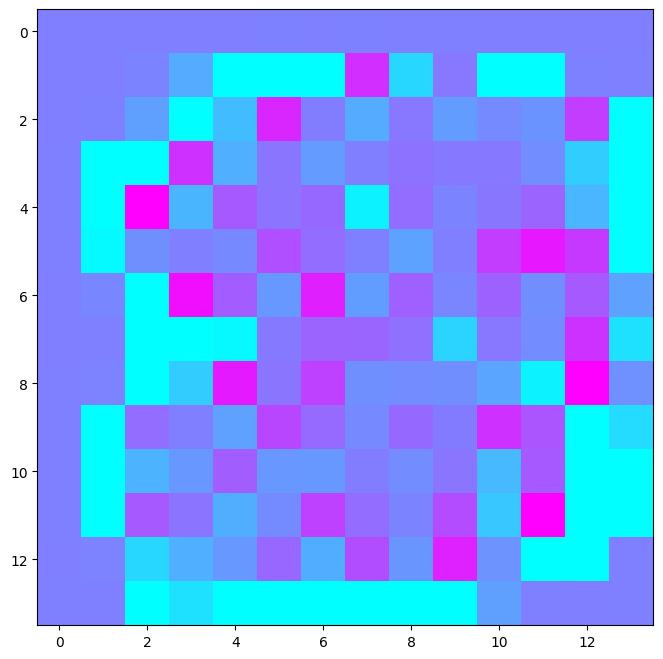

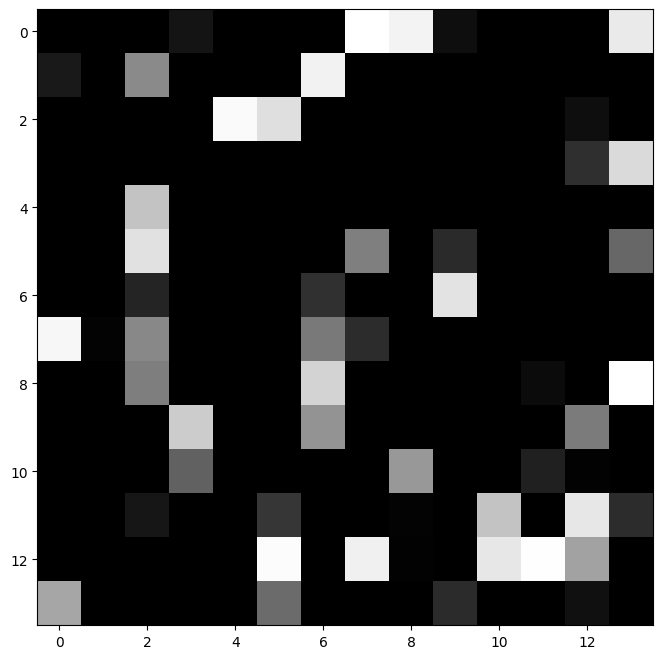

N=     1: score=    0.6967067467
N=     2: score=    0.2954618683
N=     3: score=    0.2270596313
N=     4: score=    0.1190390495
N=     5: score=    0.0540091239
N=     6: score=    0.0340005872
N=     7: score=    0.0185143469
N=     8: score=    0.0105583436
N=     9: score=    0.0059006104
N=    10: score=    0.0033308529
N=    11: score=    0.0018819415
N=    12: score=    0.0010696353
N=    13: score=    0.0006107751
N=    14: score=    0.0003504146
N=    15: score=    0.0002016547
N=    16: score=    0.0001161327
N=    17: score=    0.0000667174
N=    18: score=    0.0000381050
N=    19: score=    0.0000215689
N=    20: score=    0.0000120717
N=    21: score=    0.0000066713
N=    22: score=    0.0000036383
N=    23: score=    0.0000019582
N=    24: score=    0.0000010408
N=    25: score=    0.0000005468
N=    26: score=    0.0000002843
N=    27: score=    0.0000001466
N=    28: score=    0.0000000751
N=    29: score=    0.0000000383
N=    30: score=    0.0000000194
N=    31: 

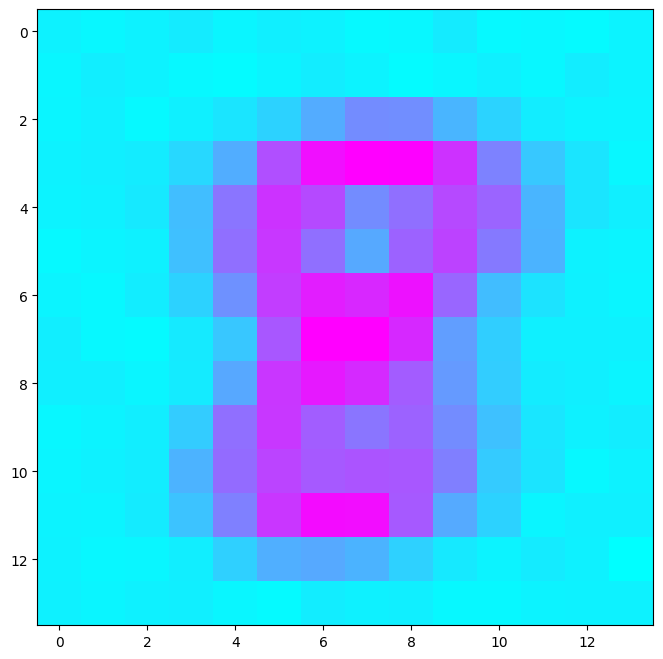

In [ ]:
# Looking at numerical values:
pprint.pprint(opt_params[:-1].round(2).reshape(14, 14).tolist(), width=200)
# "Clipping outliers" which provide a lot of evidence.
pyplot.imshow(numpy.clip(opt_params[:-1].reshape(14, 14), -10, 10), cmap='cool')
pyplot.show()
#
# We observe that there are some pixels 'just outside where a figure-8
# would normally have ink' that yield strong negative evidence, while some
# pixels that sit where we naturally would expect a figure-8 to be
# to provide mild positive evidence, the more the less likely any of the other
# digits are to have ink there.

# Let us build an alternative training set that consists of digits-8 plus
# "noise with statistically the same pixel-brightness distribution".
training_14x14 = as_14x14(images_training)
# These are only the digits-8.
training_14x14_digit8 = training_14x14[labels_training == 8]
# We start by repeating this dataset of digits-8 nine times.
# On these copies, we randomly shuffle the 196 pixels, so we get "noise images"
# which however have the same ink-distributions as our digit-8 samples.
training_14x14_clones = numpy.tile(training_14x14_digit8, [9, 1, 1])
rng = numpy.random.RandomState(seed=0)  # For reproducibility.
# Per-pixel ink-values are in [0..1]. We rescale to [0..0.5], then add a
# random integer, rescale to [num_samples, 14*14], sort along the total-pixels
# axis according to ink-value, and throw away the integral part and scale back.

random_14x14 = (
     (0.5 * training_14x14_clones).reshape(-1, 14*14) +
     rng.randint(1, 10**9, size=(training_14x14_clones.shape[0], 14*14)))
random_14x14.sort(axis=-1)
training_random_14x14 = numpy.concatenate(
    [training_14x14_digit8,
     (random_14x14.reshape(-1, 14, 14) % 1) * 2],
     axis=0)

pyplot.imshow(training_random_14x14[-1], cmap='gray'); pyplot.show()


opt_params_rand, classifier_rand = get_digit8_classifier(
    training_random_14x14,
    [8] * len(training_14x14_digit8) + [0] * len(training_14x14_digit8) * 9,
    debug_print_every_n_calls=1)

# Showing the per-pixel-evidence-contribution for this classifier would
# be naturally expected to give us something like an "averaged digit-8".
# This is indeed what happens here.
pyplot.imshow(numpy.clip(opt_params_rand[:-1].reshape(14, 14), -10, 10),
              cmap='cool')
pyplot.show()

# Discussion

A few concluding remarks. As we have seen, a substantial fraction of ML applications are based on the idea of "probabilistically doing the right thing". This means that the question "how the training set was sampled" plays a very important role. Also, we leave it to the model to "discover", via training, what (correlation-)properties of input data might give clues that could be useful for the task at hand.

As a consequence, this "empirical risk minimization based" approach to "Artificial Intelligence" has a rather visible tendency to see and interpret the world that is quite different from how humans see the world.

Our current model architecture - and also the one we will discuss next - has an interesting property: the relative arrangement of pixels does not matter. So, if we decided on one particular way to randomly reshuffle ("scramble") of all the $14\times 14$, respectively $28\times 28$ input pixels, and applied that same transformation to all training and test images, this would not impact classifier performance - whereas a human would be hopelessly lost with such a task.

Also, with this approach, there is a risk of models discovering that some particular "input data constellations" are "rarely seen on the training set, but tell-tale signs", so, "if these are present, this should contribute a lot of evidence that overshadows other signals". But then, if we use such a model on input data drawn from a different distribution than th one we drew training examples from, this can readily lead to mis-classifications where every actually intelligent interpreter of the data would wonder: "What the hell is going on?"

## How things can go wrong

One illustrative such sample has been given in the paper "[Can Your AI Differentiate Cats from Covid](https://www.semanticscholar.org/paper/Can-Your-AI-Differentiate-Cats-from-Covid-19Sample-Mallick-Dwivedi/c100c33afbb2efa5197f7d6042022e1227c5e298) - see Figure 1 from that publication.

Another similar such problem, observed in a model with text awareness, even made newspaper headlines such as with this article: [https://www.theguardian.com/technology/2021/mar/08/typographic-attack-pen-paper-fool-ai-thinking-apple-ipod-clip](https://www.theguardian.com/technology/2021/mar/08/typographic-attack-pen-paper-fool-ai-thinking-apple-ipod-clip) - the underlying research is "[Multimodal neurons in artificial neural networks](https://distill.pub/2021/multimodal-neurons/)".

A highly relevant question for applications hence is: Can we understand how a particular classification produced by a ML model happened? Can we explore the justification for a given classification? For Deep Learning, the answer is pretty much always: No, except in quite unusual circumstances, where something very clever was done to allow this.

### Adversarial attacks

Given that we know how to backpropagate gradients, we can of course also ask the question: Given a particular input, say an image, and a classification, how sensitive is the classification with respect to not model parameter changes (which is what we use in training), but input data changes - so, "what's the fastest way to distort this image of a penguin to make the model think this is a zebra?" Unfortunately, ML models can easily be sensitive to very low-amplitude correlations "which cannot be accidental", so just distorting an input image a little bit - if we have (say) gradients that give us some hint where to go - can utterly fool many a ML classifier.

The study of "adversarial attacks" on ML systems has a long history, with many inreresting publications. To quote from just one such paper, [https://arxiv.org/abs/1412.6572 - Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572):

```
8 WHY DO ADVERSARIAL EXAMPLES GENERALIZE?

An intriguing aspect of adversarial examples is that an example
generated for one model is often misclassified by other models, even
when they have different architecures or were trained on disjoint
training sets. Moreover, when these different models misclassify an
adversarial example, they often agree with each other on its
class. Explanations based on extreme non-linearity and overfitting
cannot readily account for this behavior—why should multiple extremely
non-linear model with excess capacity consistently label
out-of-distribution points in the same way? This behavior is
especially surprising from the view of the hypothesis that adversarial
examples finely tile space like the rational numbers among the reals,
because in this view adversarial examples are common but occur only at
very precise locations.

Under the linear view, adversarial examples occur in broad
subspaces. The direction eta need only have positive dot product with
the gradient of the cost function, and epsilon need only be large
enough.  Fig. 4 demonstrates this phenomenon. By tracing out different
values of epsilon we see that adversarial examples occur in contiguous
regions of the 1-D subspace defined by the fast gradient sign method,
not in fine pockets. This explains why adversarial examples are
abundant and why an example misclassified by one classifier has a
fairly high prior probability of being misclassified by another
classifier.
```

### Generative Models

Exploration of the phenomenon of adversarial attacks soon gave rise to the idea of pitching one ML model against another in a co-evolutionary "arms race" - with one model trying to generate plausible-looking random data (such as images trying to mimic portrait photos), and the other model trying to tell apart synthetic data from real data. While (co-)training such set-ups is a bit tricky, the results can be quite spectacular - see e.g. [https://www.whichfaceisreal.com/](https://www.whichfaceisreal.com/) for a demo-and-game.

# Appendices

## Complex Backpropagation

Most ML practitioners only encounter the need to do complex-backpropagation when they try to extract signals from Fourier transformed audio data.

Naturally, situations where intermediate quantities are complex are much more common in theoretical physics, so it makes sense to spend some time on ensuring we understand how this works all the way down to the lowest level.

The code further up did incidentally use complex-backprop in one place (when working out coordinates of vertices along a ring on which a membrane
ends), but this use case was non-essential, and we might easily have done this with real numbers only.

The general situation is: We have a real-valued objective function, but the calculation uses complex intermediate results.

It is still meaningful to change perspective and see each individual real/imaginary part as a real intermediate quantity that comes with its own sensitivity-accumulator. Also, it is still meaningful to ask: "by how much would the end result change if I intercepted the forward calculation and changed this intermediate quantity by $\epsilon$"?

The open question then is: Can we lift all this back interpret these real-part-sensitivities and complex-part-sensitivities in terms of performing complex operations?

Let us look at "our final result is the imaginary part of a complex intermediate quantity", and "the calculation consists of multiplying the real input with `A+1j*B`":
```
def example(x):
  A, B = 10, 20j
  C = A + 1j * B
  result_c = C * x
  result = result_c.imag
  return result
```

If we instead wrote this as...:
```
def example_v2(x):
  A, B = 10, 20j
  result_c_re = A * x
  result_c_im = B * x
  return result_c_im
```
...it is immediately clear that our sensitivity is: `s_x = B * s_result_c_im`:

```
def example_v2_backprop(x):
  A, B = 10, 20j
  s_x = 0.0
  result_c_re = A * x
  result_c_im = B * x
  # return result_c_im
  s_result_c_im = 1
  s_x += B * s_result_c_im
```
...however, if, on the original code, we did
`s_result_c = 0+1j; s_x += C * s_result_c`, this would be off - we would get `s_x = -B` rather than `s_x = B`. The answer is straightforward: If we regard complex numbers as ${\mathbb R}^2$-vectors, then complex sensitivities "live in the dual vector space", ${\mathbb R}^{2,*}$, and hence we need to complex-conjugate. This is basically the same story as with $dz=dx+i\,dy$ vs. $\frac{\partial}{\partial z} = \frac{\partial}{\partial x}-i\,\frac{\partial}{\partial y}$.